### Multi-task Learning
(Developed from dacon_etri_base_mod4_1.ipynb)
* 전처리 - MinMaxScaler 또는 RobustScaler 통일
* 파생변수 변경  
* 변수선정 

In [1]:
from datetime import datetime

# 현재 날짜 및 시간 가져오기
now = datetime.now()
timestamp = now.strftime("%m%d_%H%M")  # 예: 0517_1530


# ---------(submission_folder)--------- # 
# kmjng
submission_folder = '/home/user/miniconda3/envs/gpu_conda/src/lifelog-sleep-ictc-2025/minjeong/submission/'

# # kmjng-nb
# submission_folder = 'C:/Users/minjeong/Documents/my_env/env1/src/lifelog-sleep-ictc-2025/minjeong/submission'

# # mei 
# submission_folder = 'C:/Users/EC21RNC/works/.venv/src/mei/lifelog/submission/'


# ------------(base_folder)------------ # 

# # mei 
# base_folder = 'C:/Users/EC21RNC/works/.venv/src/mei/lifelog/ETRI_lifelog_dataset'


# kmjng
base_folder =  '/home/user/miniconda3/envs/gpu_conda/src/data/ETRI_lifelog_dataset'

# # kmjng-nb
# base_folder = 'C:/Users/minjeong/Documents/my_env/env1/src/data/ETRI_lifelog_dataset'

folder = '/ch2025_data_items'


# ------------------------------ # 
data_dir = base_folder + folder 
submission_file = f'submission_final_mod5_{timestamp}.csv'



In [2]:

import numpy as np 
import pandas as pd 
import glob 
import random 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns 
import ast 
import warnings
warnings.filterwarnings('ignore') 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import torch
import tensorflow as tf 


2025-06-07 22:50:50.419067: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-07 22:50:50.421888: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 22:50:50.460819: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 22:50:50.462276: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-07 22:50:51.254272: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
# seed 고정 
SD = 42 
random.seed(SD) 
np.random.seed(SD) 
os.environ['PYTHONHASHSEED'] = str(SD)
tf.random.set_seed(SD)  # TensorFlow 시드 설정

# 파일 경로 설정 - VSCode 상대경로로 변경
# 실제 경로에 맞게 수정 필요


# Parquet 파일 전체 경로 리스트 
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet')) 

In [4]:
# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리 
lifelog_data = {} 

# 파일별로 읽기 
for file_path in parquet_files: 
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '') 
    lifelog_data[name] = pd.read_parquet(file_path) 
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}") 

# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당 
for key, df in lifelog_data.items(): 
    globals()[f"{key}_df"] = df 

✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: wPedo, shape = (748100, 9)
✅ Loaded: mUsageStats, shape = (45197, 3)


In [5]:
# 메트릭스 파일 읽기
metrics_train = pd.read_csv(base_folder + '/ch2025_metrics_train.csv')
sample_submission = pd.read_csv(base_folder+'/ch2025_submission_sample.csv')

# ✅ 기준 쌍 (subject_id, lifelog_date) 
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date']) 
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date)) 

# ✅ DataFrame 별 timestamp 컬럼 수동 지정 
dataframes = { 
    'mACStatus': (mACStatus_df, 'timestamp'), 
    'mActivity': (mActivity_df, 'timestamp'), 
    'mAmbience': (mAmbience_df, 'timestamp'), 
    'mBle': (mBle_df, 'timestamp'), 
    'mGps': (mGps_df, 'timestamp'), 
    'mLight': (mLight_df, 'timestamp'), 
    'mScreenStatus': (mScreenStatus_df, 'timestamp'), 
    'mUsageStats': (mUsageStats_df, 'timestamp'), 
    'mWifi': (mWifi_df, 'timestamp'), 
    'wHr': (wHr_df, 'timestamp'), 
    'wLight': (wLight_df, 'timestamp'), 
    'wPedo': (wPedo_df, 'timestamp'), 
} 

In [6]:
# ✅ 분리 함수 
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'): 
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce') 
    df = df.dropna(subset=[timestamp_col]) 
    df['date_only'] = df[timestamp_col].dt.date 
    df['key'] = list(zip(df[subject_col], df['date_only'])) 
    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    return test_df, train_df 


In [7]:
# ✅ 결과 저장 
for name, (df, ts_col) in dataframes.items(): 
    print(f"⏳ {name} 분리 중...") 
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col) 
    globals()[f"{name}_test"] = test_df 
    globals()[f"{name}_train"] = train_df 
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}") 

⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (603493, 3)
⏳ mUsageStats 분리 중...
✅ mUsageStats_test → (16499, 3), mUsageStats_train → (28698, 3)
⏳ mWifi 분리 중...
✅ mWifi_test → (27467, 3), mWifi_train → (48869, 3)
⏳ wHr 분리 중...
✅ wHr_test → (143311, 3), wHr_train → (239607, 3)
⏳ wLight 분리 중...
✅ wLight_test → (233809, 3), wLight_train → (399932, 3)
⏳ wPedo 분리 중...
✅ wPedo_test → (288832, 9), wPedo_train → (459268, 9)


In [8]:
def process_mACStatus(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df = df.sort_values(['subject_id', 'timestamp']) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_charging'].values # 0/1 상태 
        times = group['timestamp'].values # 충전 상태 비율 
        ratio_charging = status.mean() 
        # 상태 전이 횟수 
        transitions = (status[1:] != status[:-1]).sum() 
        # 연속된 1 상태 길이들 
        lengths = [] 
        current_len = 0 
        for val in status: 
            if val == 1: 
                current_len += 1 
            elif current_len > 0: 
                lengths.append(current_len) 
                current_len = 0 
        if current_len > 0: 
            lengths.append(current_len) 
        avg_charging_duration = np.mean(lengths) if lengths else 0 
        max_charging_duration = np.max(lengths) if lengths else 0 
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            'charging_ratio': ratio_charging, 
            'charging_transitions': transitions, 
            'avg_charging_duration': avg_charging_duration, 
            'max_charging_duration': max_charging_duration, 
        }) 
    return pd.DataFrame(results) 

mACStatus_df2 = process_mACStatus(mACStatus_df) 

In [9]:
def process_mActivity(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        counts = group['m_activity'].value_counts(normalize=True) # 비율 
        row = {'subject_id': subj, 'date': date} 
        # 0~8 비율 저장 
        for i in range(9): 
            row[f'activity_{i}_ratio'] = counts.get(i, 0) 
        # 주요 활동 정보 
        row['dominant_activity'] = group['m_activity'].mode()[0] 
        row['num_unique_activities'] = group['m_activity'].nunique() 
        summary.append(row) 
    return pd.DataFrame(summary) 

mActivity_df2 = process_mActivity(mActivity_df) 

In [10]:
mActivity_df2['activity_2_ratio'].value_counts(ascending=False)

activity_2_ratio
0    700
Name: count, dtype: int64

In [11]:
mActivity_df2.drop(columns=['activity_2_ratio', 'activity_5_ratio','activity_6_ratio'], axis=1, inplace=True) # 2번('bicycle'), 5번('tilting'), 6번 모두 0

In [12]:
mActivity_df2.head(3)

,subject_id,date,activity_0_ratio,activity_1_ratio,activity_3_ratio,activity_4_ratio,activity_7_ratio,activity_8_ratio,dominant_activity,num_unique_activities
0,id01,2024-06-26,0.125176,0.001406,0.672293,0.157525,0.043601,0.0,3,5
1,id01,2024-06-27,0.146528,0.000000,0.611111,0.220833,0.021528,0.0,3,4
2,id01,2024-06-28,0.111806,0.000694,0.861806,0.000694,0.025000,0.0,3,5


In [13]:
# 지정된 10개 라벨 
top_10_labels = [ 
    "Inside, small room", "Speech", "Silence", "Music", "Narration, monologue", 
    "Child speech, kid speaking", "Conversation", "Speech synthesizer", "Shout", "Babbling" 
] 

def process_mAmbience_top10(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    # 초기화 
    for label in top_10_labels + ['others']: 
        df[label] = 0.0 
    for idx, row in df.iterrows(): 
        parsed = ast.literal_eval(row['m_ambience']) if isinstance(row['m_ambience'], str) else row['m_ambience'] 
        others_prob = 0.0 
        for label, prob in parsed: 
            prob = float(prob) 
            if label in top_10_labels: 
                df.at[idx, label] = prob 
            else: 
                others_prob += prob 
        df.at[idx, 'others'] = others_prob 
    return df.drop(columns=['m_ambience']) 

mAmbience_df2= process_mAmbience_top10(mAmbience_df) 

In [14]:
def summarize_mAmbience_daily(df): 
    prob_cols = [col for col in df.columns if col not in ['subject_id', 'timestamp', 'date']] 
    # 하루 단위로 평균값 요약 
    daily_summary = df.groupby(['subject_id', 'date'])[prob_cols].mean().reset_index() 
    return daily_summary 

mAmbience_df2 = summarize_mAmbience_daily(mAmbience_df2) 


### mBle (블루투스 장치)
> 이 데이터는 위치 기반 행동 패턴, 사회적 상호작용, 일상 루틴 분석에 유용 
* RSSI = 신호 강도 (Received Signal Strength Indicator): 
 값이 0에 가까울수록 장치가 가까이 있음 (-30dBm > -70dBm)  
* device_class_0_ratio (0~1):  
 전체 감지된 장치 중 "클래스 0" 장치의 비율  
 보통 스마트폰, 태블릿 등 개인 장치    
* device_class_others_ratio (0~1):  
기타 장치들의 비율 (헤드폰, 스피커, IoT 기기 등)   
(--)   
device_class_0_ratio가 높으면 → 사람들(스마트폰) 근처에 많이 있었음  
device_class_others_ratio가 높으면 → IoT가 많은 환경 (카페, 사무실 등) 

In [15]:
def process_mBle(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for idx, row in df.iterrows(): 
        entry = ast.literal_eval(row['m_ble']) if isinstance(row['m_ble'], str) else row['m_ble'] 
        rssi_list = [] 
        class_0_cnt = 0 
        class_other_cnt = 0 
        class_7936_cnt = 0  # 추가
        class_1796_cnt = 0  # 추가


        for device in entry: 
            try: 
                rssi = int(device['rssi']) 
                rssi_list.append(rssi) 
                device_class = str(device['device_class'])
                if device_class == '0': 
                    class_0_cnt += 1 
                elif device_class == '7936':  # 추가
                    class_7936_cnt += 1
                elif device_class == '1796':  # 추가
                    class_1796_cnt += 1
                else: 
                    class_other_cnt += 1 
            except: 
                continue 

        feature = { 
            'subject_id': row['subject_id'], 
            'date': row['date'], 
            'device_class_0_cnt': class_0_cnt, 
            'device_class_others_cnt': class_other_cnt, 
            'device_class_7936_cnt': class_7936_cnt,  # 추가
            'device_class_1796_cnt': class_1796_cnt,  # 추가
            'device_count': len(rssi_list), 
            'rssi_mean': np.mean(rssi_list) if rssi_list else np.nan, 
            'rssi_min': np.min(rssi_list) if rssi_list else np.nan, 
            'rssi_max': np.max(rssi_list) if rssi_list else np.nan, 
        } 
        features.append(feature) 
    return pd.DataFrame(features)

In [16]:
def summarize_mBle_daily(df): 
    df = process_mBle(df) 
    grouped = df.groupby(['subject_id', 'date']).agg({ 
        'device_class_0_cnt': 'sum', 
        'device_class_others_cnt': 'sum', 
        'device_class_7936_cnt': 'sum',  # 추가
        'device_class_1796_cnt': 'sum',  # 추가
        'rssi_mean': 'mean', 
        'rssi_min': 'min', 
        'rssi_max': 'max', 
    }).reset_index() 
    
    total_cnt = grouped['device_class_0_cnt'] + grouped['device_class_others_cnt'] + grouped['device_class_7936_cnt'] + grouped['device_class_1796_cnt']
    grouped['device_class_0_ratio'] = grouped['device_class_0_cnt'] / total_cnt.replace(0, np.nan) 
    grouped['device_class_others_ratio'] = grouped['device_class_others_cnt'] / total_cnt.replace(0, np.nan) 
    grouped['device_class_7936_ratio'] = grouped['device_class_7936_cnt'] / total_cnt.replace(0, np.nan)  # 추가
    grouped['device_class_1796_ratio'] = grouped['device_class_1796_cnt'] / total_cnt.replace(0, np.nan)  # 추가
    
    grouped.drop(columns=['device_class_0_cnt', 'device_class_others_cnt', 'device_class_7936_cnt', 'device_class_1796_cnt'], inplace=True) 
    return grouped

mBle_df2 = summarize_mBle_daily(mBle_df) 


In [17]:
print(mBle_df.head(4))
print(mBle_df['m_ble'][0][0])
print(mBle_df2.columns)


all_classes = [device['device_class'] 
               for ble_array in mBle_df['m_ble'] if ble_array is not None
               for device in ble_array]

device_counts = pd.Series(all_classes).value_counts()
print(device_counts)

  subject_id           timestamp  \
0       id01 2024-06-26 12:13:00   
1       id01 2024-06-26 12:23:00   
2       id01 2024-06-26 12:33:00   
3       id01 2024-06-26 13:23:00   

                                               m_ble  
0  [{'address': '00:15:7C:11:80:8D', 'device_clas...  
1  [{'address': '0A:B1:26:4D:76:21', 'device_clas...  
2  [{'address': '04:F5:AE:39:95:E0', 'device_clas...  
3  [{'address': '06:C0:D2:6D:9F:69', 'device_clas...  
{'address': '00:15:7C:11:80:8D', 'device_class': '0', 'rssi': -82}
Index(['subject_id', 'date', 'rssi_mean', 'rssi_min', 'rssi_max',
       'device_class_0_ratio', 'device_class_others_ratio',
       'device_class_7936_ratio', 'device_class_1796_ratio'],
      dtype='object')
0       385700
7936     45002
1796      2524
          1144
1084       967
524        662
1060       443
1280       382
284        146
1024        30
1408        15
1344        15
1064         9
1028         5
1044         5
2324         3
1048         1
256         

### (*) GPS 값

In [18]:
def process_mGps(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for idx, row in df.iterrows(): 
        gps_list = ast.literal_eval(row['m_gps']) if isinstance(row['m_gps'], str) else row['m_gps'] 
        altitudes = [] 
        latitudes = [] 
        longitudes = [] 
        speeds = [] 
        for entry in gps_list: 
            try: 
                altitudes.append(float(entry['altitude'])) 
                latitudes.append(float(entry['latitude'])) 
                longitudes.append(float(entry['longitude'])) 
                speeds.append(float(entry['speed'])) 
            except: 
                continue 
        features.append({ 
            'subject_id': row['subject_id'], 
            'date': row['date'], 
            'altitude_mean': np.mean(altitudes) if altitudes else np.nan, 
            'latitude_std': np.std(latitudes) if latitudes else np.nan, 
            'longitude_std': np.std(longitudes) if longitudes else np.nan, 
            'speed_mean': np.mean(speeds) if speeds else np.nan, 
            'speed_max': np.max(speeds) if speeds else np.nan, 
            'speed_std': np.std(speeds) if speeds else np.nan, 
        }) 
    return pd.DataFrame(features) 

In [19]:
m_Gps_df2 = process_mGps(mGps_df) 
m_Gps_df2 = m_Gps_df2.groupby(['subject_id', 'date']).agg({ 
    'altitude_mean': 'mean', 
    'latitude_std': 'mean', 
    'longitude_std': 'mean', 
    'speed_mean': 'mean', 
    'speed_max': 'max', 
    'speed_std': 'mean' 
}).reset_index() 

### (*) 주변 빛 (mobile 측정)

In [20]:
def process_mLight(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['hour'] = df['timestamp'].dt.hour 
    # 밤(22~05시), 낮(06~21시) 구분 
    df['is_night'] = df['hour'].apply(lambda h: h >= 22 or h < 6) 
    # 하루 단위 요약 
    daily = df.groupby(['subject_id', 'date']).agg( 
        light_mean=('m_light', 'mean'), 
        light_std=('m_light', 'std'), 
        light_max=('m_light', 'max'), 
        light_min=('m_light', 'min'), 
        light_night_mean=('m_light', lambda x: x[df.loc[x.index, 'is_night']].mean()), 
        light_day_mean=('m_light', lambda x: x[~df.loc[x.index, 'is_night']].mean()), 
        light_night_ratio=('is_night', 'mean') # 밤 시간 측정 비율 
    ).reset_index() 
    return daily 

mLight_df2 = process_mLight(mLight_df) 

### (*) 스마트폰 화면 사용 중 여부 

- 추가 파생변수: 밤 시간 사용, 낮 시간 사용 여부 

In [21]:
def process_mScreenStatus(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['hour'] = df['timestamp'].dt.hour  # 시간 정보 추가
    
    features = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_screen_use'].values 
        hours = group['hour'].values  # 해당 그룹의 시간 정보
        
        # 기존 특성들
        ratio_on = status.mean() 
        transitions = (status[1:] != status[:-1]).sum() 
        
        # 연속된 1 상태 길이들 
        durations = [] 
        current = 0 
        for val in status: 
            if val == 1: 
                current += 1 
            elif current > 0: 
                durations.append(current) 
                current = 0 
        if current > 0: 
            durations.append(current) 
            
        # 시간대별 사용 패턴 추가
        # 밤 시간대 (22시-05시) 스크린 사용
        night_mask = (hours >= 22) | (hours <= 5)
        night_screen_usage = status[night_mask].mean() if night_mask.any() else 0
        
        # 낮 시간대 (06시-21시) 스크린 사용  
        day_mask = (hours >= 6) & (hours <= 21)
        day_screen_usage = status[day_mask].mean() if day_mask.any() else 0
        
        features.append({ 
            'subject_id': subj, 
            'date': date, 
            'screen_on_ratio': ratio_on, 
            'screen_on_transitions': transitions, 
            'screen_on_duration_avg': np.mean(durations) if durations else 0, 
            'screen_on_duration_max': np.max(durations) if durations else 0,
            'night_screen_usage': night_screen_usage,  # 밤시간 스크린 사용 비율
            'day_screen_usage': day_screen_usage,      # 낮시간 스크린 사용 비율
        }) 
    return pd.DataFrame(features)

mScreenStatus_df2 = process_mScreenStatus(mScreenStatus_df) 


In [22]:
# 분포가 너무 치우쳐있는지 확인
print(mScreenStatus_df['m_screen_use'].value_counts())
# 만약 0이 99%, 1이 1%라면 정보량이 적을 수 있음

m_screen_use
0    725047
1    214606
Name: count, dtype: int64


In [23]:
mScreenStatus_df2.head(4)

,subject_id,date,screen_on_ratio,screen_on_transitions,screen_on_duration_avg,screen_on_duration_max,night_screen_usage,day_screen_usage
0,id01,2024-06-26,0.295359,54,7.777778,60,0.552632,0.246231
1,id01,2024-06-27,0.365734,82,12.756098,79,0.161702,0.465625
2,id01,2024-06-28,0.319718,90,10.088889,51,0.091489,0.432632
3,id01,2024-06-29,0.237857,66,10.090909,82,0.008511,0.353763


In [24]:
mUsageStats_df.head(2)

,subject_id,timestamp,m_usage_stats
0,id01,2024-06-26 13:00:00,"[{'app_name': ' 캐시워크', 'total_time': 69}, {'ap..."
1,id01,2024-06-26 13:10:00,"[{'app_name': '통화', 'total_time': 26419}, {'ap..."


In [25]:
# 모든 앱 데이터를 하나의 리스트로 합치기 (추가)
all_apps = []
for stats in mUsageStats_df['m_usage_stats']:
    all_apps.extend(stats)  # numpy array든 list든 extend로 합치기

# DataFrame으로 변환
app_df = pd.DataFrame(all_apps)
top_10 = app_df.groupby('app_name')['total_time'].sum().sort_values(ascending=False).head(10)

print("가장 많이 사용된 앱 TOP 10:")
for i, (app, time) in enumerate(top_10.items(), 1):
    print(f"{i}. {app}: {time}분")



가장 많이 사용된 앱 TOP 10:
1. One UI 홈: 4655575663분
2. 시스템 UI: 2598865909분
3. 카카오톡: 2408771919분
4. NAVER: 1156302340분
5. YouTube: 806269206분
6.  ✝️성경일독Q: 778709744분
7.  캐시워크: 555842806분
8. Instagram: 554532193분
9. 통화: 448883450분
10. Microsoft Launcher: 440910412분


In [26]:
# top_20 = app_df.groupby('app_name')['total_time'].sum().sort_values(ascending=False).head(20)
# top_20.index

# # 기존 top_apps
# # top_apps = [ 
# #     'One UI 홈', '카카오톡', '시스템 UI', 'NAVER', '캐시워크', 
# #     '성경일독Q', 'YouTube', '통화', '메시지', '타임스프레드', 'Instagram'
# # ] 
# top_apps = top_20.index

# def process_mUsageStats(df): 
#     df = df.copy() 
#     df['timestamp'] = pd.to_datetime(df['timestamp']) 
#     df['date'] = df['timestamp'].dt.date 
#     features = [] 
#     for (subj, date), group in df.groupby(['subject_id', 'date']): 
#         app_time = {app: 0 for app in top_apps} 
#         others_time = 0 
#         for row in group['m_usage_stats']: 
#             parsed = ast.literal_eval(row) if isinstance(row, str) else row 
#             for entry in parsed: 
#                 app = entry.get('app_name') 
#                 time = entry.get('total_time', 0) 
#                 if app in top_apps: 
#                     app_time[app] += int(time) 
#                 else: 
#                     others_time += int(time) 
#         feature = { 
#             'subject_id': subj, 
#             'date': date, 
#             'others_time': others_time 
#         } 
#         # 각 앱별 컬럼 추가 
#         feature.update({f'{app}_time': app_time[app] for app in top_apps}) 
#         features.append(feature) 
#     return pd.DataFrame(features) 

# mUsageStats_df2 = process_mUsageStats(mUsageStats_df) 

In [27]:
# 앱 사용 시간 (합계)
mUsageStats_df3 = mUsageStats_df.copy() 
# 방법 1: 기존 DataFrame에 새로운 컬럼 추가
def calculate_total_usage_time(usage_stats):
    """m_usage_stats에서 모든 앱의 total_time 합계 계산"""
    total_time = 0
    for app in usage_stats:
        total_time += app['total_time']
    return total_time

# m_usage_time 컬럼 추가
mUsageStats_df3['m_usage_time'] = mUsageStats_df3['m_usage_stats'].apply(calculate_total_usage_time)

# # 결과 확인
# print("새로운 컬럼이 추가된 DataFrame:")
# print(mUsageStats_df3[['subject_id', 'timestamp', 'm_usage_time']].head())


# # 전체 구조 확인
# print(f"\nDataFrame shape: {mUsageStats_df3.shape}")
# print(f"Columns: {mUsageStats_df3.columns.tolist()}")

mUsageStats_df3 = mUsageStats_df3[['subject_id', 'timestamp', 'm_usage_time']]

# 간단한 방법: 날짜별 사용시간 합계
mUsageStats_df3['date'] = pd.to_datetime(mUsageStats_df3['timestamp']).dt.date

# 날짜별 합계 계산
mUsageStats_df3 = mUsageStats_df3.groupby(['subject_id', 'date'])['m_usage_time'].sum().reset_index()



In [28]:
mUsageStats_df3.head(2)

,subject_id,date,m_usage_time
0,id01,2024-06-26,25418119
1,id01,2024-06-27,54102878


### (*) Wifi 신호   
* wifi_rssi_mean(평균 수신 신호 세기(RSSI)): 수면 중 움직임이 적을 때 신호 변화가 작아질 수 있음.   
* wifi_rssi_min(최소 수신 신호 세기): 환경적 변화(예: 몸의 이동, 장애물 등)에 민감. 수면 중 큰 움직임(뒤척임 등) 감지에 활용 가능성  
* wifi_detected_cnt(WiFi 신호 감지 횟수): 스마트폰 등 단말의 네트워크 이벤트(접속/해제, 트래픽 등) 빈도와 수면/각성 상태가 밀접히 연관됨  

In [29]:
mWifi_df.head(3)

,subject_id,timestamp,m_wifi
0,id01,2024-06-26 12:03:00,"[{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -78}, ..."
1,id01,2024-06-26 12:13:00,"[{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -79}, ..."
2,id01,2024-06-26 12:23:00,"[{'bssid': '10:e3:c7:0a:74:d1', 'rssi': -78}, ..."


In [30]:
mWifi_df.m_wifi[0][0]

{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -78}

In [31]:
def process_mWifi(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['hour'] = df['timestamp'].dt.hour
    
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        # 시간대별로 데이터 분리
        afternoon_data = group[(group['hour'] >= 12) & (group['hour'] < 18)]  # 12-18시
        night_data = group[(group['hour'] >= 18) & (group['hour'] < 24)]      # 18-24시  
        midnight_data = group[(group['hour'] >= 0) & (group['hour'] < 6)]     # 0-6시
        
        def extract_rssi(data):
            rssi_list = []
            for row in data['m_wifi']:
                parsed = ast.literal_eval(row) if isinstance(row, str) else row 
                for ap in parsed: 
                    try: 
                        rssi = int(ap['rssi']) 
                        rssi_list.append(rssi) 
                    except: 
                        continue 
            return rssi_list
        
        # 각 시간대별 RSSI 추출
        afternoon_rssi = extract_rssi(afternoon_data)
        night_rssi = extract_rssi(night_data)
        midnight_rssi = extract_rssi(midnight_data)
        
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            # 오후 (12-18시)
            'afternoon_wifi_rssi_mean': np.mean(afternoon_rssi) if afternoon_rssi else np.nan,
            'afternoon_wifi_rssi_std': np.std(afternoon_rssi) if afternoon_rssi else np.nan,
            'afternoon_wifi_detected_cnt': len(afternoon_rssi),
            
            # 밤 (18-24시)  
            'night_wifi_rssi_mean': np.mean(night_rssi) if night_rssi else np.nan,
            'night_wifi_rssi_std': np.std(night_rssi) if night_rssi else np.nan,
            'night_wifi_detected_cnt': len(night_rssi),
            
            # # 자정 (0-6시)
            # 'midnight_wifi_rssi_mean': np.mean(midnight_rssi) if midnight_rssi else np.nan,
            # 'midnight_wifi_rssi_std': np.std(midnight_rssi) if midnight_rssi else np.nan,
            # 'midnight_wifi_detected_cnt': len(midnight_rssi),
        }) 
    return pd.DataFrame(results) 

mWifi_df2 = process_mWifi(mWifi_df) 
mWifi_df2

,subject_id,date,afternoon_wifi_rssi_mean,afternoon_wifi_rssi_std,afternoon_wifi_detected_cnt,night_wifi_rssi_mean,night_wifi_rssi_std,night_wifi_detected_cnt
0,id01,2024-06-26,-72.036217,12.386738,497,-68.208696,14.965465,460
1,id01,2024-06-27,-73.362229,12.714125,323,-67.161585,18.331004,328
2,id01,2024-06-28,-72.929260,12.480267,311,-65.041935,17.819929,310
3,id01,2024-06-29,-71.326034,14.117021,411,-64.490272,19.074116,257
4,id01,2024-06-30,-73.211581,12.737271,449,-63.260417,18.910743,288
...,...,...,...,...,...,...,...,...
680,id10,2024-09-21,-71.640227,13.722390,353,-72.092742,12.637768,496
681,id10,2024-09-22,-72.205418,13.282510,443,-69.657841,13.578205,491
682,id10,2024-09-24,-70.651786,13.732593,560,-73.130604,11.434213,513
683,id10,2024-09-25,-66.057377,16.627697,732,-71.866221,11.839598,299


In [32]:
# mWifi_df2.midnight_wifi_rssi_std.isnull().sum()

In [33]:
# 기존 코드 
# def process_mWifi(df): 
#     df = df.copy() 
#     df['timestamp'] = pd.to_datetime(df['timestamp']) 
#     df['date'] = df['timestamp'].dt.date 
#     results = [] 
#     for (subj, date), group in df.groupby(['subject_id', 'date']): 
#         rssi_all = [] 
#         for row in group['m_wifi']: 
#             parsed = ast.literal_eval(row) if isinstance(row, str) else row 
#             for ap in parsed: 
#                 try: 
#                     rssi = int(ap['rssi']) 
#                     rssi_all.append(rssi) 
#                 except: 
#                     continue 
#         results.append({ 
#             'subject_id': subj, 
#             'date': date, 
#             'wifi_rssi_mean': np.mean(rssi_all) if rssi_all else np.nan, 
#             'wifi_rssi_std': np.std(rssi_all) if rssi_all else np.nan,  # 표준편차 추가 
#             'wifi_rssi_min': np.min(rssi_all) if rssi_all else np.nan,  
#             'wifi_rssi_max': np.max(rssi_all) if rssi_all else np.nan, 
#             'wifi_detected_cnt': len(rssi_all) 
#         }) 
#     return pd.DataFrame(results) 

# mWifi_df2 = process_mWifi(mWifi_df) 
# mWifi_df2

* 심박수

In [34]:

def get_time_block(hour): 
    if 0 <= hour < 6: 
        return 'early_morning' 
    elif 6 <= hour < 12: 
        return 'morning' 
    elif 12 <= hour < 18: 
        return 'afternoon' 
    else: 
        return 'evening' 

def process_wHr_by_timeblock(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        for block, block_group in group.groupby('block'): 
            hr_all = [] 
            for row in block_group['heart_rate']: 
                parsed = ast.literal_eval(row) if isinstance(row, str) else row 
                hr_all.extend([int(h) for h in parsed if h is not None]) 
            if not hr_all: 
                continue 
            above_100 = [hr for hr in hr_all if hr > 100] 
            block_stats[f'hr_{block}_mean'] = np.mean(hr_all) 
            block_stats[f'hr_{block}_std'] = np.std(hr_all) 
            block_stats[f'hr_{block}_max'] = np.max(hr_all) 
            block_stats[f'hr_{block}_min'] = np.min(hr_all) 
            block_stats[f'hr_{block}_above_100_ratio'] = len(above_100) / len(hr_all) 
        results.append(block_stats) 
    return pd.DataFrame(results) 

wHr_df2 = process_wHr_by_timeblock(wHr_df) 

# 결측 많은 피쳐 드롭 
drop_cols = [ 'hr_early_morning_mean',
   'hr_early_morning_std',
   'hr_early_morning_max',
   'hr_early_morning_min',
   'hr_early_morning_above_100_ratio']

wHr_df2.drop(columns=drop_cols, axis=1, inplace=True) # 드롭 


* 심박수 파생변수 추가   
> 밤-낮 심박수 차이, 정상심박수 비율, 심박수 안정성

In [35]:
import ast 

def get_time_block_no_early(hour): 
    if 6 <= hour < 12: 
        return 'morning' 
    elif 12 <= hour < 18: 
        return 'afternoon' 
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return None

def process_wHr_with_features_only(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block_no_early) 
    
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        
        # 전체 일일 심박수 데이터 수집
        all_day_hr = []
        day_hr = []    # 낮 (6-18시): morning + afternoon
        night_hr = []  # 밤 (18-24시): evening만
        
        valid_group = group[group['block'].notna()]
        
        for block, block_group in valid_group.groupby('block'): 
            hr_all = [] 
            for row in block_group['heart_rate']: 
                parsed = ast.literal_eval(row) if isinstance(row, str) else row 
                hr_all.extend([int(h) for h in parsed if h is not None]) 
            
            if not hr_all: 
                continue 
            
            all_day_hr.extend(hr_all)
            
            # 낮/밤 분류만 하고 시간대별 통계는 제거
            if block in ['morning', 'afternoon']:
                day_hr.extend(hr_all)
            elif block == 'evening':
                night_hr.extend(hr_all)
        
        # 파생변수 3개
        if day_hr and night_hr:
            block_stats['day_night_hr_diff'] = np.mean(day_hr) - np.mean(night_hr)
        else:
            block_stats['day_night_hr_diff'] = np.nan
        
        if all_day_hr:
            normal_hr = [hr for hr in all_day_hr if 60 <= hr <= 100]
            block_stats['normal_hr_ratio'] = len(normal_hr) / len(all_day_hr)
        else:
            block_stats['normal_hr_ratio'] = np.nan
        
        if all_day_hr and len(all_day_hr) > 1:
            hr_mean = np.mean(all_day_hr)
            hr_std = np.std(all_day_hr)
            block_stats['hr_stability'] = hr_std / hr_mean if hr_mean > 0 else np.nan
        else:
            block_stats['hr_stability'] = np.nan
            
        results.append(block_stats) 
    
    return pd.DataFrame(results) 

# 실행
wHr_df3 = process_wHr_with_features_only(wHr_df)
# print(wHr_df3.columns.tolist())

wHr_df3 = pd.merge(wHr_df2, wHr_df3, on=['subject_id', 'date'], how='inner')


In [36]:
wHr_df3.head(3)

,subject_id,date,hr_afternoon_mean,hr_afternoon_std,hr_afternoon_max,hr_afternoon_min,hr_afternoon_above_100_ratio,hr_evening_mean,hr_evening_std,hr_evening_max,hr_evening_min,hr_evening_above_100_ratio,hr_morning_mean,hr_morning_std,hr_morning_max,hr_morning_min,hr_morning_above_100_ratio,day_night_hr_diff,normal_hr_ratio,hr_stability
0,id01,2024-06-26,80.533300,12.636566,142.0,59.0,0.077268,82.476838,10.293221,124.0,59.0,0.055503,NaN,NaN,NaN,NaN,NaN,-1.943538,0.930558,0.146119
1,id01,2024-06-27,87.405165,12.296994,125.0,63.0,0.179430,83.526477,10.967673,122.0,61.0,0.082859,72.343956,10.333083,130.0,53.0,0.023445,-7.571946,0.925296,0.158047
2,id01,2024-06-28,83.013953,12.488545,135.0,55.0,0.099419,75.821333,9.176060,109.0,59.0,0.018667,78.775349,12.413443,120.0,51.0,0.072774,3.314891,0.922346,0.156781


### (*) 주변 빛 (Watch 측정)

In [37]:

def process_wLight_by_timeblock(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        for block, block_group in group.groupby('block'): 
            lux = block_group['w_light'].dropna().values 
            if len(lux) == 0: 
                continue 
            block_stats[f'wlight_{block}_mean'] = np.mean(lux) 
            block_stats[f'wlight_{block}_std'] = np.std(lux) 
            block_stats[f'wlight_{block}_max'] = np.max(lux) 
            block_stats[f'wlight_{block}_min'] = np.min(lux) 
        results.append(block_stats) 
    return pd.DataFrame(results) 

wLight_df2 = process_wLight_by_timeblock(wLight_df)

### (*) 걸음 수 (Watch 측정)

In [38]:
def process_wPedo(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = df.groupby(['subject_id', 'date']).agg({ 
        'step': 'sum', 
        'step_frequency': 'mean', 
        'distance': 'sum', 
        'speed': ['mean', 'max'], 
        'burned_calories': 'sum' 
    }).reset_index() 
    # 컬럼 이름 정리 
    summary.columns = ['subject_id', 'date', 'step_sum', 'step_frequency_mean', 'distance_sum', 'speed_mean', 'speed_max', 'burned_calories_sum'] 
    return summary 

wPedo_df2 = process_wPedo(wPedo_df) 

## [★] 데이터셋 & 모델링 준비

In [39]:

from functools import reduce 
df_list = [ 
    mACStatus_df2, 
    mActivity_df2,  
    mAmbience_df2,  
    mBle_df2, # 파생변수 추가
    m_Gps_df2, 
    mLight_df2, 
    mScreenStatus_df2, # 파생변수 추가
    mUsageStats_df3, # mUsageStats_df2, 
    mWifi_df2, # 파생변수 추가
    wHr_df3 , # wHr_df2, 
    wLight_df2, 
    wPedo_df2 
] 

merged_df = reduce(lambda left, right: pd.merge(left, right, on=['subject_id', 'date'], how='outer'), df_list) 


In [40]:
# merged_df.columns

* train, test

In [41]:

# metrics_train의 lifelog_date → datetime.date 형으로 변환 
metrics_train['lifelog_date'] = pd.to_datetime(metrics_train['lifelog_date']).dt.date 

# merged_df의 date도 변환 
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date 

# 1. date 기준 정렬을 위해 metrics_train의 lifelog_date -> date로 맞추기 
metrics_train_renamed = metrics_train.rename(columns={'lifelog_date': 'date'}) 

# 2. train_df: metrics_train과 일치하는 (subject_id, date) → 라벨 포함 
train_df = pd.merge(metrics_train_renamed, merged_df, on=['subject_id', 'date'], how='inner') 

# 3. test_df: metrics_train에 없는 (subject_id, date) 
merged_keys = merged_df[['subject_id', 'date']] 
train_keys = metrics_train_renamed[['subject_id', 'date']] 
test_keys = pd.merge(merged_keys, train_keys, on=['subject_id', 'date'], how='left', indicator=True) 
test_keys = test_keys[test_keys['_merge'] == 'left_only'].drop(columns=['_merge']) 
test_df = pd.merge(test_keys, merged_df, on=['subject_id', 'date'], how='left') 


In [42]:

# ✅ 타겟 리스트 
targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3'] 
target_multiclass = 'S1' 

# ✅ feature 준비 
X = train_df.drop(columns=['subject_id', 'sleep_date', 'date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']) 
X.fillna(0, inplace=True) # 결측값 처리 

test_X = test_df.drop(columns=['subject_id', 'date']) 
test_X.fillna(0, inplace=True) 


In [43]:

# 컬럼 이름에서 특수 문자 제거/변환 
def sanitize_column_names(df): 
    df.columns = ( 
        df.columns 
        .str.replace(r"[^\w]", "_", regex=True) # 특수문자 → _ 
        .str.replace(r"__+", "_", regex=True) # 연속된 _ 제거 
        .str.strip("_") # 앞뒤 _ 제거 
    ) 
    return df 

# 모든 입력에 적용 
X = sanitize_column_names(X) 
test_X = sanitize_column_names(test_X) 


# ✅ 데이터 준비
print(f"Features shape: {X.shape}")
print(f"Feature names: {list(X.columns)}")

Features shape: (450, 96)
Feature names: ['charging_ratio', 'charging_transitions', 'avg_charging_duration', 'max_charging_duration', 'activity_0_ratio', 'activity_1_ratio', 'activity_3_ratio', 'activity_4_ratio', 'activity_7_ratio', 'activity_8_ratio', 'dominant_activity', 'num_unique_activities', 'Inside_small_room', 'Speech', 'Silence', 'Music', 'Narration_monologue', 'Child_speech_kid_speaking', 'Conversation', 'Speech_synthesizer', 'Shout', 'Babbling', 'others', 'rssi_mean', 'rssi_min', 'rssi_max', 'device_class_0_ratio', 'device_class_others_ratio', 'device_class_7936_ratio', 'device_class_1796_ratio', 'altitude_mean', 'latitude_std', 'longitude_std', 'speed_mean_x', 'speed_max_x', 'speed_std', 'light_mean', 'light_std', 'light_max', 'light_min', 'light_night_mean', 'light_day_mean', 'light_night_ratio', 'screen_on_ratio', 'screen_on_transitions', 'screen_on_duration_avg', 'screen_on_duration_max', 'night_screen_usage', 'day_screen_usage', 'm_usage_time', 'afternoon_wifi_rssi_mea

### 1. 변수 선정 - SHAP value

In [44]:
TOP_N = 25

분석할 타겟: ['Q1', 'Q2', 'Q3', 'S2', 'S3', 'S1']
특성 개수: 96
샘플 개수: 450
타겟별 Shapley value 계산 중...
Processing Q1...
Processing Q2...
Processing Q3...
Processing S2...
Processing S3...
Processing S1...

종합 중요도 계산 중...

=== 상위 20개 중요 변수 ===
 1. device_class_7936_ratio: 0.0116
 2. night_wifi_detected_cnt: 0.0107
 3. light_night_mean: 0.0103
 4. rssi_max: 0.0091
 5. charging_ratio: 0.0090
 6. device_class_0_ratio: 0.0088
 7. m_usage_time: 0.0084
 8. screen_on_ratio: 0.0083
 9. night_screen_usage: 0.0081
10. rssi_min: 0.0079
11. screen_on_duration_avg: 0.0079
12. normal_hr_ratio: 0.0074
13. light_day_mean: 0.0072
14. device_class_1796_ratio: 0.0069
15. light_max: 0.0068
16. light_mean: 0.0067
17. day_screen_usage: 0.0065
18. wlight_evening_mean: 0.0065
19. activity_7_ratio: 0.0064
20. light_std: 0.0063
21. afternoon_wifi_rssi_mean: 0.0062
22. altitude_mean: 0.0062
23. night_wifi_rssi_std: 0.0061
24. max_charging_duration: 0.0059
25. activity_3_ratio: 0.0058


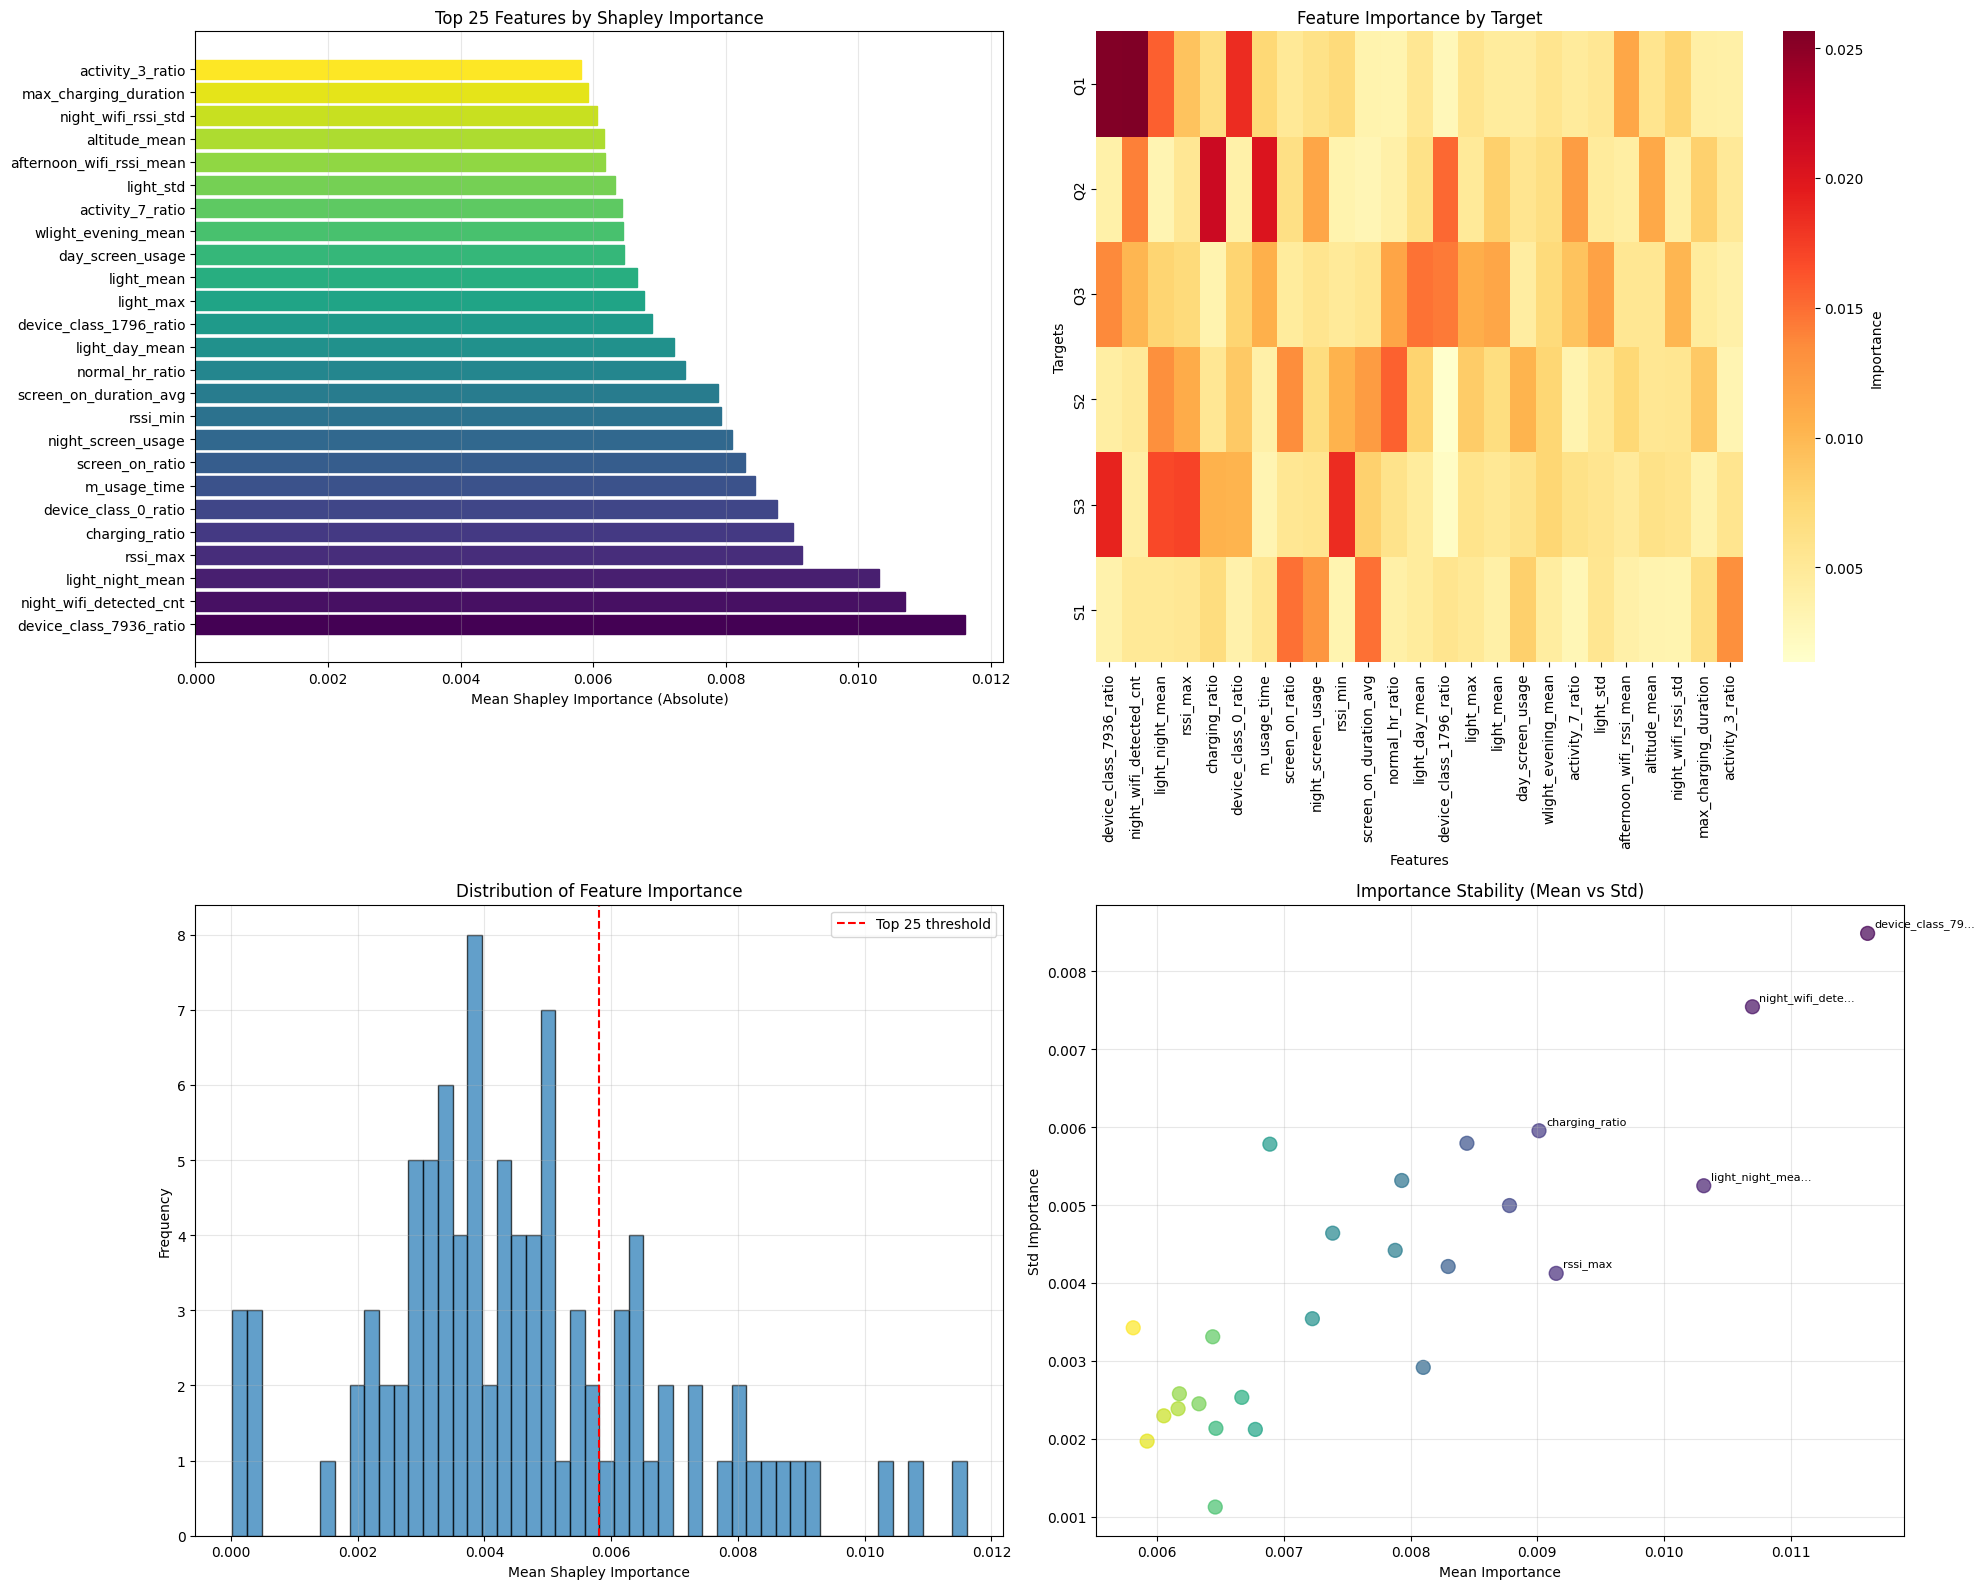


선택된 특성으로 데이터셋 크기: (450, 25)

상위 25개 변수의 상세 정보:
                          rank  mean_importance  std_importance
device_class_7936_ratio      1           0.0116          0.0085
night_wifi_detected_cnt      2           0.0107          0.0075
light_night_mean             3           0.0103          0.0052
rssi_max                     4           0.0091          0.0041
charging_ratio               5           0.0090          0.0060
device_class_0_ratio         6           0.0088          0.0050
m_usage_time                 7           0.0084          0.0058
screen_on_ratio              8           0.0083          0.0042
night_screen_usage           9           0.0081          0.0029
rssi_min                    10           0.0079          0.0053
screen_on_duration_avg      11           0.0079          0.0044
normal_hr_ratio             12           0.0074          0.0046
light_day_mean              13           0.0072          0.0035
device_class_1796_ratio     14           0.0069         

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
import shap
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def calculate_multivariate_shapley_importance(X, y_dict, top_n=20):
    """
    다변량 타겟에 대한 Shapley value 기반 변수 중요도 계산
    """
    
    # 1. 전체 데이터에 RobustScaler 적용
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X), 
        columns=X.columns, 
        index=X.index
    )
    
    # 2. 각 타겟별 Shapley value 계산
    all_shapley_values = {}
    feature_importance_by_target = {}
    
    print("타겟별 Shapley value 계산 중...")
    
    for target_name, y in y_dict.items():
        print(f"Processing {target_name}...")
        
        # 결측값 제거
        valid_idx = ~y.isna()
        X_valid = X_scaled[valid_idx]  # 스케일링된 데이터 사용
        y_valid = y[valid_idx]
        
        if len(y_valid.unique()) <= 1:
            print(f"Warning: {target_name} has only one unique value, skipping...")
            continue
            
        # 분류 모델
        model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        
        # 모델 학습 (스케일링된 데이터 사용)
        model.fit(X_valid, y_valid)
        
        # SHAP explainer 생성 (TreeExplainer 사용)
        explainer = shap.TreeExplainer(model)
        
        # Shapley values 계산 (샘플 수가 많으면 일부만 사용)
        sample_size = min(1000, len(X_valid))
        X_sample = X_valid.sample(n=sample_size, random_state=42)
        shap_values = explainer.shap_values(X_sample)
        # 
        # 다중클래스 분류의 경우 처리
        if isinstance(shap_values, list):
            # 여러 클래스의 shap values를 절대값 평균으로 통합
            combined_shap = np.mean([np.abs(sv) for sv in shap_values], axis=0)
            feature_importance = combined_shap.mean(axis=0)
        else:
            # 이진분류 또는 회귀의 경우
            if len(shap_values.shape) == 3:  # 3차원인 경우 (n_samples, n_features, n_classes)
                # 클래스별 절대값 평균
                feature_importance = np.abs(shap_values).mean(axis=(0, 2))
            else:  # 2차원인 경우 (n_samples, n_features)
                feature_importance = np.abs(shap_values).mean(axis=0)
        
        # SHAP values 저장 (시각화용)
        if isinstance(shap_values, list):
            all_shapley_values[target_name] = shap_values[0]  # 첫 번째 클래스만 저장
        else:
            if len(shap_values.shape) == 3:
                all_shapley_values[target_name] = shap_values[:, :, 0]  # 첫 번째 클래스만 저장
            else:
                all_shapley_values[target_name] = shap_values
        feature_importance_by_target[target_name] = pd.Series(
            feature_importance, 
            index=X_valid.columns
        )
    
    # 2. 타겟별 중요도를 평균내어 종합 중요도 계산
    print("\n종합 중요도 계산 중...")
    
    # 모든 타겟에 공통으로 있는 특성들만 사용
    common_features = set(X.columns)
    for importance in feature_importance_by_target.values():
        common_features = common_features.intersection(set(importance.index))
    
    common_features = list(common_features)
    
    # 타겟별 중요도를 DataFrame으로 정리
    importance_matrix = pd.DataFrame(index=common_features)
    for target_name, importance in feature_importance_by_target.items():
        importance_matrix[target_name] = importance[common_features]
    
    # 평균 중요도 계산 (각 타겟의 가중치는 동일)
    importance_matrix['mean_importance'] = importance_matrix.mean(axis=1)
    importance_matrix['std_importance'] = importance_matrix.std(axis=1)
    
    # 상위 변수 선택
    top_features = importance_matrix.nlargest(top_n, 'mean_importance').index.tolist()
    
    return top_features, importance_matrix, all_shapley_values, feature_importance_by_target

def plot_feature_importance(importance_df, top_n=TOP_N):
    """변수 중요도 시각화"""
    
    # 상위 변수들
    top_importance = importance_df.nlargest(top_n, 'mean_importance')
    
    # 1. 종합 중요도 바 플롯
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 상위 변수 바 플롯
    ax1 = axes[0, 0]
    bars = ax1.barh(range(len(top_importance)), top_importance['mean_importance'])
    ax1.set_yticks(range(len(top_importance)))
    ax1.set_yticklabels(top_importance.index, fontsize=10)
    ax1.set_xlabel('Mean Shapley Importance (Absolute)')
    ax1.set_title(f'Top {top_n} Features by Shapley Importance')
    ax1.grid(axis='x', alpha=0.3)
    
    # 색상 그라데이션 적용
    colors = plt.cm.viridis(np.linspace(0, 1, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # 2. 타겟별 중요도 히트맵
    ax2 = axes[0, 1]
    target_cols = [col for col in importance_df.columns if col not in ['mean_importance', 'std_importance']]
    if target_cols:
        heatmap_data = top_importance[target_cols].T
        sns.heatmap(heatmap_data, annot=False, cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Importance'})
        ax2.set_title('Feature Importance by Target')
        ax2.set_xlabel('Features')
        ax2.set_ylabel('Targets')
    
    # 3. 중요도 분포
    ax3 = axes[1, 0]
    ax3.hist(importance_df['mean_importance'], bins=50, alpha=0.7, edgecolor='black')
    ax3.axvline(top_importance['mean_importance'].min(), color='red', linestyle='--', 
                label=f'Top {top_n} threshold')
    ax3.set_xlabel('Mean Shapley Importance')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Feature Importance')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # 4. 상위 변수들의 안정성 (표준편차)
    ax4 = axes[1, 1]
    scatter = ax4.scatter(top_importance['mean_importance'], top_importance['std_importance'], 
                         c=range(len(top_importance)), cmap='viridis', alpha=0.7, s=100)
    ax4.set_xlabel('Mean Importance')
    ax4.set_ylabel('Std Importance')
    ax4.set_title('Importance Stability (Mean vs Std)')
    ax4.grid(alpha=0.3)
    
    # 상위 5개 변수에 라벨 추가
    for i, (idx, row) in enumerate(top_importance.head().iterrows()):
        ax4.annotate(idx[:15] + '...' if len(idx) > 15 else idx, 
                    (row['mean_importance'], row['std_importance']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# 메인 실행 코드
if __name__ == "__main__":
    # 타겟 딕셔너리 생성
    y_dict = {}
    for target in targets_binary:
        y_dict[target] = train_df[target]
    y_dict[target_multiclass] = train_df[target_multiclass]
    
    print(f"분석할 타겟: {list(y_dict.keys())}")
    print(f"특성 개수: {X.shape[1]}")
    print(f"샘플 개수: {X.shape[0]}")
    
    # Shapley 중요도 계산
    top_features, importance_df, shap_values, target_importance = calculate_multivariate_shapley_importance(
        X, y_dict, top_n=TOP_N
    )
    
    # 결과 출력
    print(f"\n=== 상위 20개 중요 변수 ===")
    for i, feature in enumerate(top_features, 1):
        importance = importance_df.loc[feature, 'mean_importance']
        print(f"{i:2d}. {feature}: {importance:.4f}")
    
    # 시각화
    plot_feature_importance(importance_df, top_n=TOP_N)
    
    # 선택된 특성으로 새로운 데이터셋 생성
    X_selected = X[top_features]
    test_X_selected = test_X[top_features] if 'test_X' in locals() else None
    
    print(f"\n선택된 특성으로 데이터셋 크기: {X_selected.shape}")
    
    # 결과 저장용 DataFrame
    result_df = importance_df.nlargest(TOP_N, 'mean_importance').copy()
    result_df['rank'] = range(1, len(result_df) + 1)
    
    print(f"\n상위 {TOP_N}개 변수의 상세 정보:")
    print(result_df[['rank', 'mean_importance', 'std_importance']].round(4))

### 설명력 낮은 원인 찾기 

In [55]:
# 데이터 품질 체크
print("=== 데이터 품질 분석 ===")

# 결측값 비율
missing_ratio = X.isnull().sum() / len(X)
print(f"결측값이 50% 이상인 변수: {sum(missing_ratio > 0.5)}개")

# 분산이 너무 작은 변수 (상수에 가까운 변수)
low_variance_vars = X.var()[X.var() < 0.01].index
print(f"분산이 매우 낮은 변수: {len(low_variance_vars)}개")

# 타겟 불균형 체크
for target_name, y in y_dict.items():
    print(f"{target_name} 분포:", y.value_counts(normalize=True).round(3).to_dict())

=== 데이터 품질 분석 ===
결측값이 50% 이상인 변수: 0개
분산이 매우 낮은 변수: 20개
Q1 분포: {0: 0.504, 1: 0.496}
Q2 분포: {1: 0.562, 0: 0.438}
Q3 분포: {1: 0.6, 0: 0.4}
S2 분포: {1: 0.651, 0: 0.349}
S3 분포: {1: 0.662, 0: 0.338}
S1 분포: {1: 0.498, 0: 0.318, 2: 0.184}


### 모델 별 설명력 확인

분석할 타겟: ['Q1', 'Q2', 'Q3', 'S2', 'S3', 'S1']
특성 개수: 96
샘플 개수: 450
비교할 모델: ['RF', 'LGBM', 'GB']

모델: RF
=== RF 모델로 타겟별 Shapley value 계산 중... ===
Processing Q1...
  CV Score: 0.440 ± 0.130
Processing Q2...
  CV Score: 0.498 ± 0.055
Processing Q3...
  CV Score: 0.480 ± 0.114
Processing S2...
  CV Score: 0.547 ± 0.094
Processing S3...
  CV Score: 0.616 ± 0.045
Processing S1...
  CV Score: 0.278 ± 0.088

종합 중요도 계산 중...

모델: LGBM
=== LGBM 모델로 타겟별 Shapley value 계산 중... ===
Processing Q1...
  CV Score: 0.427 ± 0.095
Processing Q2...
  CV Score: 0.509 ± 0.067
Processing Q3...
  CV Score: 0.456 ± 0.111
Processing S2...
  CV Score: 0.551 ± 0.074
Processing S3...
  CV Score: 0.573 ± 0.046
Processing S1...
  CV Score: 0.251 ± 0.071

종합 중요도 계산 중...

모델: GB
=== GB 모델로 타겟별 Shapley value 계산 중... ===
Processing Q1...
  CV Score: 0.413 ± 0.103
Processing Q2...
  CV Score: 0.520 ± 0.037
Processing Q3...
  CV Score: 0.456 ± 0.106
Processing S2...
  CV Score: 0.547 ± 0.075
Processing S3...
  CV Score: 0.573

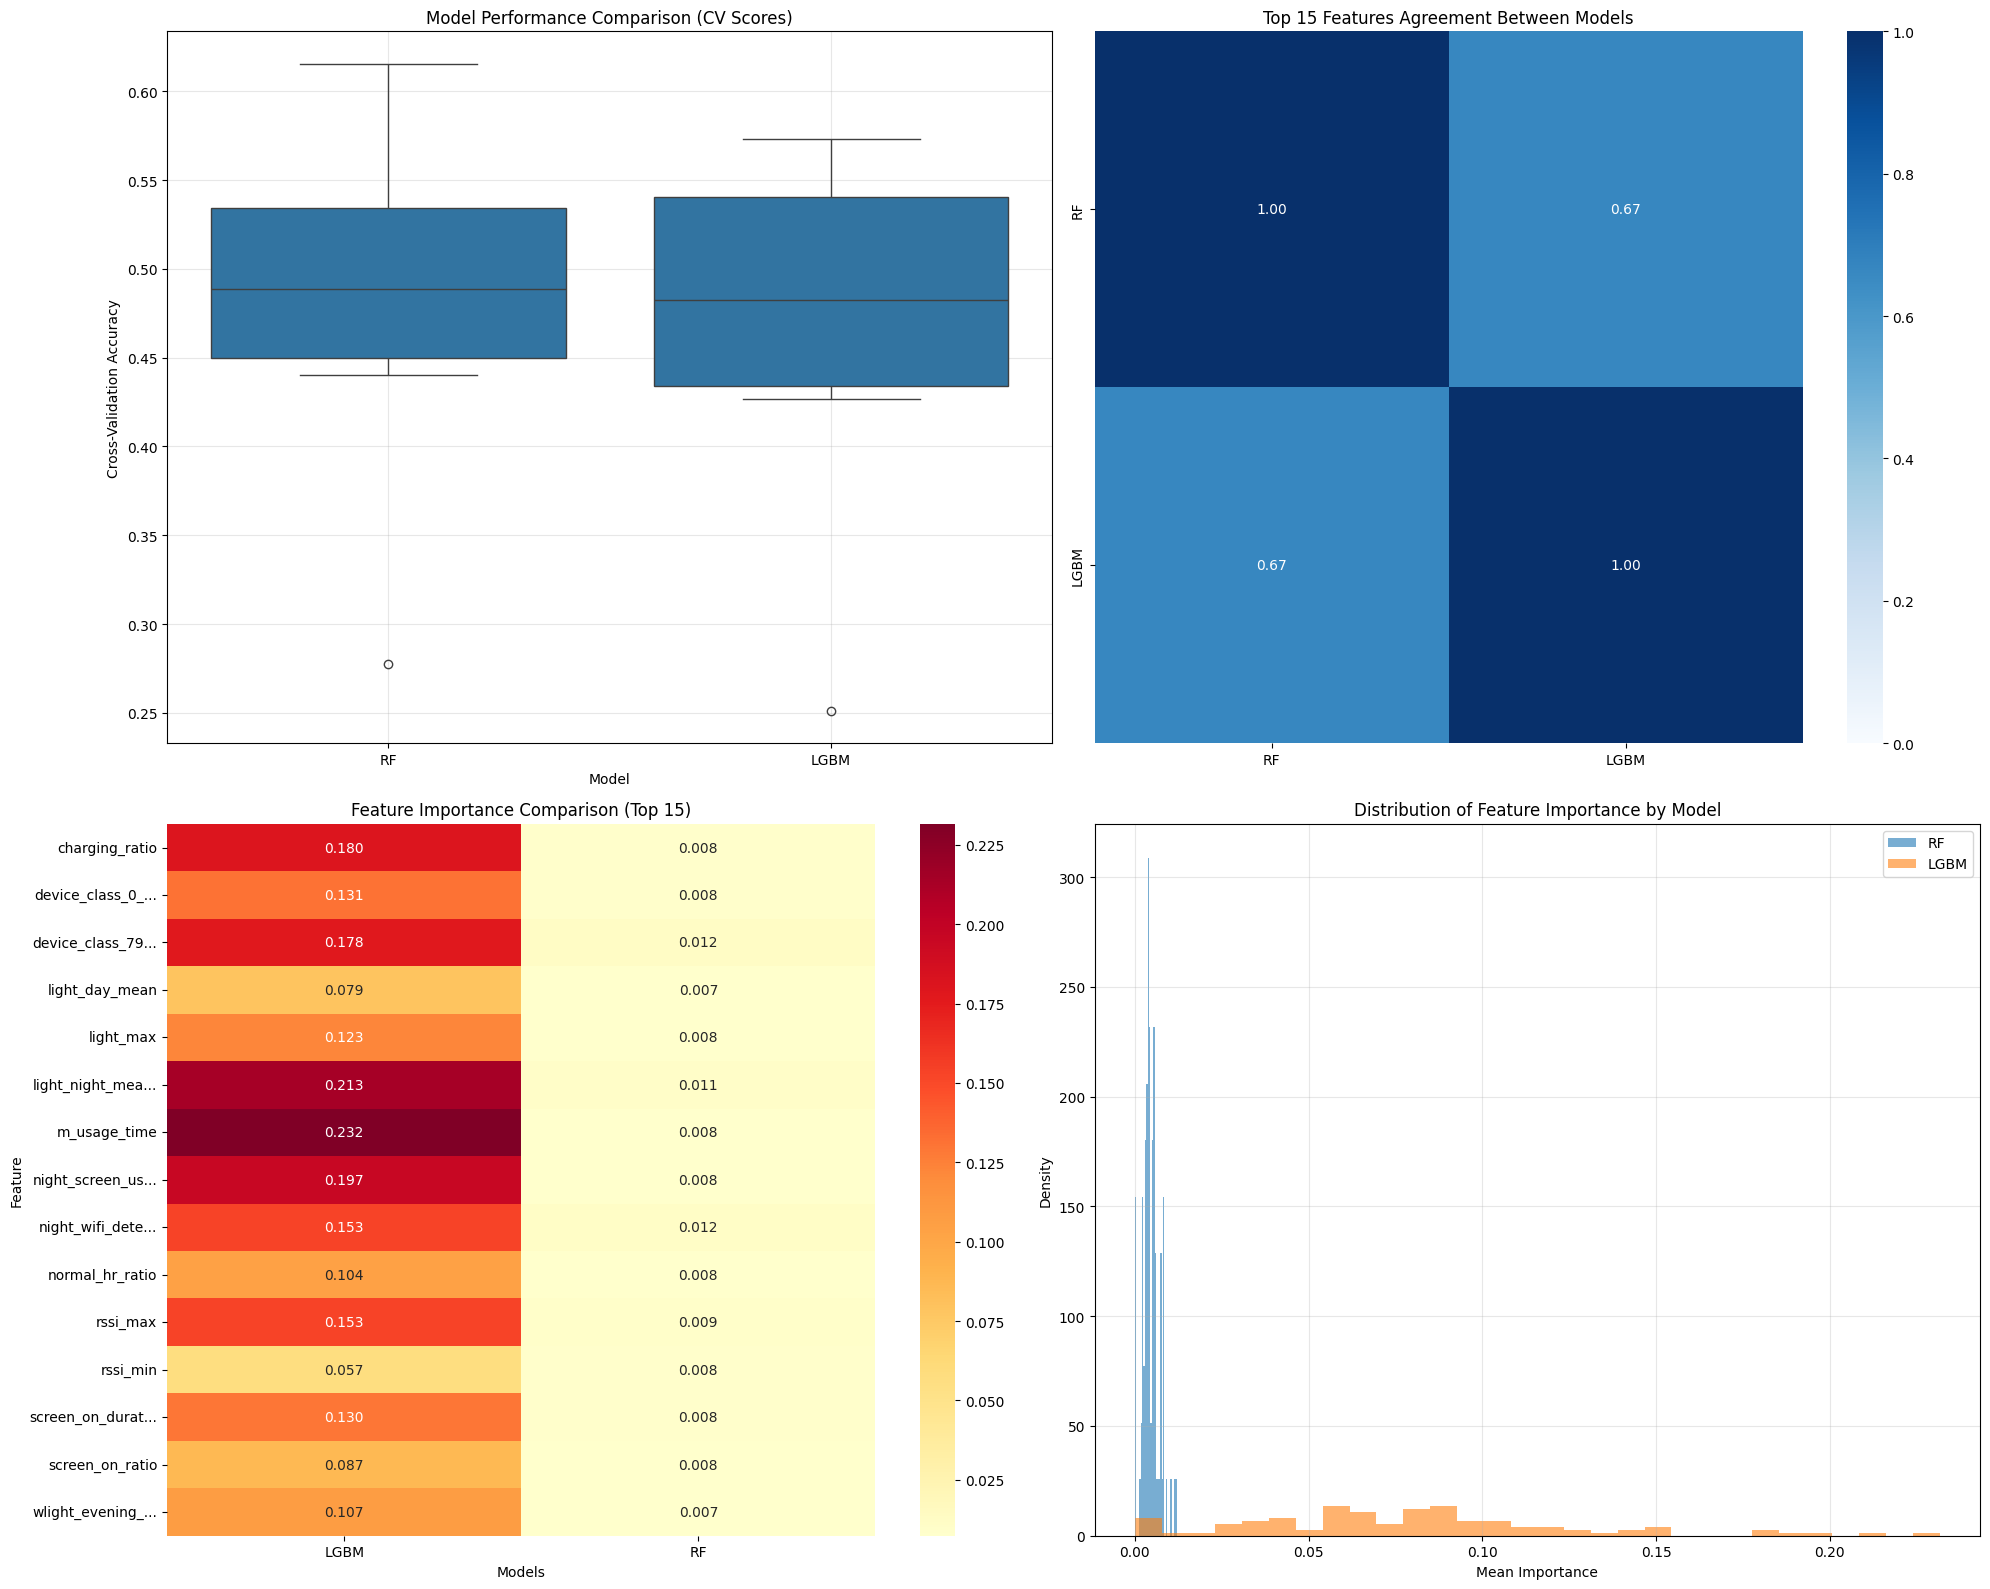

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.preprocessing import RobustScaler
# from sklearn.model_selection import cross_val_score
# import lightgbm as lgb
# import shap
# from collections import defaultdict
# import warnings
# warnings.filterwarnings('ignore')

# # 한글 폰트 설정
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['axes.unicode_minus'] = False

# def calculate_multivariate_shapley_importance(X, y_dict, model_type='RF', top_n=20):
#     """
#     다변량 타겟에 대한 Shapley value 기반 변수 중요도 계산 (여러 모델 지원)
    
#     Parameters:
#     -----------
#     X : DataFrame
#         특성 데이터
#     y_dict : dict
#         {'target_name': target_series} 형태의 타겟 딕셔너리
#     model_type : str
#         사용할 모델 타입 ('RF', 'LGBM', 'GB')
#     top_n : int
#         상위 몇 개 변수를 선택할지
    
#     Returns:
#     --------
#     top_features : list
#         상위 중요 변수 리스트
#     importance_df : DataFrame
#         변수별 중요도 정보
#     model_scores : dict
#         모델별 교차검증 점수
#     """
    
#     # 1. 전체 데이터에 RobustScaler 적용
#     scaler = RobustScaler()
#     X_scaled = pd.DataFrame(
#         scaler.fit_transform(X), 
#         columns=X.columns, 
#         index=X.index
#     )
    
#     # 2. 모델 선택
#     def get_model(model_type):
#         if model_type == 'RF':
#             return RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
#         elif model_type == 'LGBM':
#             return lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1, n_jobs=-1)
#         elif model_type == 'GB':
#             return GradientBoostingClassifier(n_estimators=100, random_state=42)
#         else:
#             raise ValueError("model_type must be one of ['RF', 'LGBM', 'GB']")
    
#     # 3. 각 타겟별 Shapley value 계산 및 모델 성능 평가
#     all_shapley_values = {}
#     feature_importance_by_target = {}
#     model_scores = {}
    
#     print(f"=== {model_type} 모델로 타겟별 Shapley value 계산 중... ===")
    
#     for target_name, y in y_dict.items():
#         print(f"Processing {target_name}...")
        
#         # 결측값 제거
#         valid_idx = ~y.isna()
#         X_valid = X_scaled[valid_idx]
#         y_valid = y[valid_idx]
        
#         if len(y_valid.unique()) <= 1:
#             print(f"Warning: {target_name} has only one unique value, skipping...")
#             continue
        
#         # 모델 생성
#         model = get_model(model_type)
        
#         # 교차검증으로 모델 성능 평가
#         try:
#             cv_scores = cross_val_score(model, X_valid, y_valid, cv=5, scoring='accuracy')
#             model_scores[target_name] = {
#                 'mean_cv_score': cv_scores.mean(),
#                 'std_cv_score': cv_scores.std(),
#                 'cv_scores': cv_scores
#             }
#             print(f"  CV Score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
#         except Exception as e:
#             print(f"  CV Score calculation failed: {e}")
#             model_scores[target_name] = {'mean_cv_score': np.nan, 'std_cv_score': np.nan}
        
#         # 모델 학습
#         model.fit(X_valid, y_valid)
        
#         # SHAP explainer 생성
#         if model_type in ['RF', 'GB']:
#             explainer = shap.TreeExplainer(model)
#         elif model_type == 'LGBM':
#             explainer = shap.TreeExplainer(model)
        
#         # Shapley values 계산 (샘플 수가 많으면 일부만 사용)
#         sample_size = min(1000, len(X_valid))
#         X_sample = X_valid.sample(n=sample_size, random_state=42)
        
#         try:
#             shap_values = explainer.shap_values(X_sample)
            
#             # 다중클래스 분류의 경우 처리
#             if isinstance(shap_values, list):
#                 # 여러 클래스의 shap values를 절대값 평균으로 통합
#                 combined_shap = np.mean([np.abs(sv) for sv in shap_values], axis=0)
#                 feature_importance = combined_shap.mean(axis=0)
#                 # 시각화용으로 첫 번째 클래스 저장
#                 all_shapley_values[target_name] = shap_values[0]
#             else:
#                 # 이진분류 또는 회귀의 경우
#                 if len(shap_values.shape) == 3:  # 3차원인 경우 (n_samples, n_features, n_classes)
#                     feature_importance = np.abs(shap_values).mean(axis=(0, 2))
#                     all_shapley_values[target_name] = shap_values[:, :, 0]
#                 else:  # 2차원인 경우 (n_samples, n_features)
#                     feature_importance = np.abs(shap_values).mean(axis=0)
#                     all_shapley_values[target_name] = shap_values
            
#             feature_importance_by_target[target_name] = pd.Series(
#                 feature_importance, 
#                 index=X_valid.columns
#             )
            
#         except Exception as e:
#             print(f"  SHAP calculation failed for {target_name}: {e}")
#             continue
    
#     # 4. 타겟별 중요도를 평균내어 종합 중요도 계산
#     print("\n종합 중요도 계산 중...")
    
#     if not feature_importance_by_target:
#         print("No valid feature importance calculated!")
#         return [], pd.DataFrame(), model_scores
    
#     # 모든 타겟에 공통으로 있는 특성들만 사용
#     common_features = set(X.columns)
#     for importance in feature_importance_by_target.values():
#         common_features = common_features.intersection(set(importance.index))
    
#     common_features = list(common_features)
    
#     # 타겟별 중요도를 DataFrame으로 정리
#     importance_matrix = pd.DataFrame(index=common_features)
#     for target_name, importance in feature_importance_by_target.items():
#         importance_matrix[target_name] = importance[common_features]
    
#     # 평균 중요도 계산 (각 타겟의 가중치는 동일)
#     importance_matrix['mean_importance'] = importance_matrix.mean(axis=1)
#     importance_matrix['std_importance'] = importance_matrix.std(axis=1)
    
#     # 상위 변수 선택
#     top_features = importance_matrix.nlargest(top_n, 'mean_importance').index.tolist()
    
#     return top_features, importance_matrix, all_shapley_values, feature_importance_by_target, model_scores

# def compare_models_shapley(X, y_dict, models=['RF', 'LGBM', 'GB'], top_n=20):
#     """
#     여러 모델로 Shapley 중요도 비교
#     """
#     results = {}
#     all_model_scores = {}
    
#     for model_type in models:
#         print(f"\n{'='*50}")
#         print(f"모델: {model_type}")
#         print('='*50)
        
#         try:
#             top_features, importance_df, shap_values, target_importance, model_scores = \
#                 calculate_multivariate_shapley_importance(X, y_dict, model_type=model_type, top_n=top_n)
            
#             results[model_type] = {
#                 'top_features': top_features,
#                 'importance_df': importance_df,
#                 'shap_values': shap_values,
#                 'target_importance': target_importance
#             }
#             all_model_scores[model_type] = model_scores
            
#         except Exception as e:
#             print(f"Error with model {model_type}: {e}")
#             continue
    
#     return results, all_model_scores

# def plot_model_comparison(results, all_model_scores, top_n=15):
#     """
#     모델별 결과 비교 시각화
#     """
#     models = list(results.keys())
    
#     fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
#     # 1. 모델별 CV 성능 비교
#     ax1 = axes[0, 0]
#     cv_data = []
#     model_names = []
#     target_names = []
    
#     for model_name, scores_dict in all_model_scores.items():
#         for target_name, scores in scores_dict.items():
#             if not np.isnan(scores['mean_cv_score']):
#                 cv_data.append(scores['mean_cv_score'])
#                 model_names.append(model_name)
#                 target_names.append(target_name)
    
#     if cv_data:
#         df_cv = pd.DataFrame({
#             'CV_Score': cv_data,
#             'Model': model_names,
#             'Target': target_names
#         })
        
#         sns.boxplot(data=df_cv, x='Model', y='CV_Score', ax=ax1)
#         ax1.set_title('Model Performance Comparison (CV Scores)')
#         ax1.set_ylabel('Cross-Validation Accuracy')
#         ax1.grid(True, alpha=0.3)
    
#     # 2. 상위 변수들의 모델간 일치도
#     ax2 = axes[0, 1]
#     if len(models) >= 2:
#         # 각 모델의 상위 변수들 추출
#         top_features_by_model = {}
#         for model_name, result in results.items():
#             if result['top_features']:
#                 top_features_by_model[model_name] = set(result['top_features'][:top_n])
        
#         # 교집합 계산
#         if len(top_features_by_model) >= 2:
#             intersection_matrix = pd.DataFrame(index=models, columns=models)
#             for model1 in models:
#                 for model2 in models:
#                     if model1 in top_features_by_model and model2 in top_features_by_model:
#                         intersection = len(top_features_by_model[model1] & top_features_by_model[model2])
#                         intersection_matrix.loc[model1, model2] = intersection / top_n
#                     else:
#                         intersection_matrix.loc[model1, model2] = np.nan
            
#             intersection_matrix = intersection_matrix.astype(float)
#             sns.heatmap(intersection_matrix, annot=True, cmap='Blues', ax=ax2, 
#                        vmin=0, vmax=1, fmt='.2f')
#             ax2.set_title(f'Top {top_n} Features Agreement Between Models')
    
#     # 3. 모델별 상위 변수 중요도 비교
#     ax3 = axes[1, 0]
#     if results:
#         # 첫 번째 모델의 상위 변수들을 기준으로 설정
#         first_model = list(results.keys())[0]
#         reference_features = results[first_model]['top_features'][:top_n]
        
#         comparison_data = []
#         for model_name, result in results.items():
#             if result['importance_df'] is not None and not result['importance_df'].empty:
#                 for feature in reference_features:
#                     if feature in result['importance_df'].index:
#                         importance = result['importance_df'].loc[feature, 'mean_importance']
#                         comparison_data.append({
#                             'Feature': feature[:15] + '...' if len(feature) > 15 else feature,
#                             'Model': model_name,
#                             'Importance': importance
#                         })
        
#         if comparison_data:
#             df_comp = pd.DataFrame(comparison_data)
            
#             # 피벗 테이블 생성
#             pivot_df = df_comp.pivot(index='Feature', columns='Model', values='Importance')
            
#             # 히트맵 그리기
#             sns.heatmap(pivot_df, annot=True, cmap='YlOrRd', ax=ax3, fmt='.3f')
#             ax3.set_title(f'Feature Importance Comparison (Top {top_n})')
#             ax3.set_xlabel('Models')
#             plt.setp(ax3.get_yticklabels(), rotation=0)
    
#     # 4. 모델별 평균 중요도 분포
#     ax4 = axes[1, 1]
#     for model_name, result in results.items():
#         if result['importance_df'] is not None and not result['importance_df'].empty:
#             importance_values = result['importance_df']['mean_importance'].values
#             ax4.hist(importance_values, bins=30, alpha=0.6, label=model_name, density=True)
    
#     ax4.set_xlabel('Mean Importance')
#     ax4.set_ylabel('Density')
#     ax4.set_title('Distribution of Feature Importance by Model')
#     ax4.legend()
#     ax4.grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.show()
    
#     return fig

# # 메인 실행 코드
# if __name__ == "__main__":
#     # 여러 모델로 비교 실행
#     models_to_compare = ['RF', 'LGBM', 'GB']
    
#     print(f"분석할 타겟: {list(y_dict.keys())}")
#     print(f"특성 개수: {X.shape[1]}")
#     print(f"샘플 개수: {X.shape[0]}")
#     print(f"비교할 모델: {models_to_compare}")
    
#     # 모델 비교 실행
#     results, all_model_scores = compare_models_shapley(X, y_dict, models=models_to_compare, top_n=20)
    
#     # 결과 요약 출력
#     print(f"\n{'='*60}")
#     print("모델별 성능 요약")
#     print('='*60)
    
#     for model_name, scores_dict in all_model_scores.items():
#         print(f"\n[{model_name}]")
#         for target_name, scores in scores_dict.items():
#             if not np.isnan(scores['mean_cv_score']):
#                 print(f"  {target_name}: {scores['mean_cv_score']:.3f} ± {scores['std_cv_score']:.3f}")
#             else:
#                 print(f"  {target_name}: Failed")
    
#     # 모델별 상위 변수 출력
#     print(f"\n{'='*60}")
#     print("모델별 상위 10개 중요 변수")
#     print('='*60)
    
#     for model_name, result in results.items():
#         print(f"\n[{model_name}]")
#         if result['top_features']:
#             for i, feature in enumerate(result['top_features'][:10], 1):
#                 if result['importance_df'] is not None and feature in result['importance_df'].index:
#                     importance = result['importance_df'].loc[feature, 'mean_importance']
#                     print(f"  {i:2d}. {feature}: {importance:.4f}")
#         else:
#             print("  No features calculated")
    
#     # 시각화
#     if results:
#         plot_model_comparison(results, all_model_scores, top_n=15)

### LGBM - SHAP value 

In [47]:
TOP_N = 25

분석할 타겟: ['Q1', 'Q2', 'Q3', 'S2', 'S3', 'S1']
특성 개수: 96
샘플 개수: 450
타겟별 Shapley value 계산 중...
Processing Q1...
Processing Q2...
Processing Q3...
Processing S2...
Processing S3...
Processing S1...

종합 중요도 계산 중...

=== 상위 20개 중요 변수 ===
 1. m_usage_time: 0.2258
 2. light_night_mean: 0.2031
 3. device_class_1796_ratio: 0.1962
 4. device_class_7936_ratio: 0.1843
 5. night_screen_usage: 0.1815
 6. charging_ratio: 0.1702
 7. night_wifi_detected_cnt: 0.1526
 8. night_wifi_rssi_mean: 0.1511
 9. activity_7_ratio: 0.1441
10. light_mean: 0.1398
11. hr_morning_min: 0.1373
12. screen_on_duration_avg: 0.1369
13. rssi_max: 0.1314
14. light_max: 0.1313
15. device_class_0_ratio: 0.1293
16. hr_evening_std: 0.1292
17. afternoon_wifi_rssi_mean: 0.1263
18. night_wifi_rssi_std: 0.1184
19. day_screen_usage: 0.1152
20. avg_charging_duration: 0.1118
21. hr_evening_max: 0.1077
22. screen_on_ratio: 0.1046
23. day_night_hr_diff: 0.1034
24. screen_on_transitions: 0.1024
25. hr_afternoon_mean: 0.1023


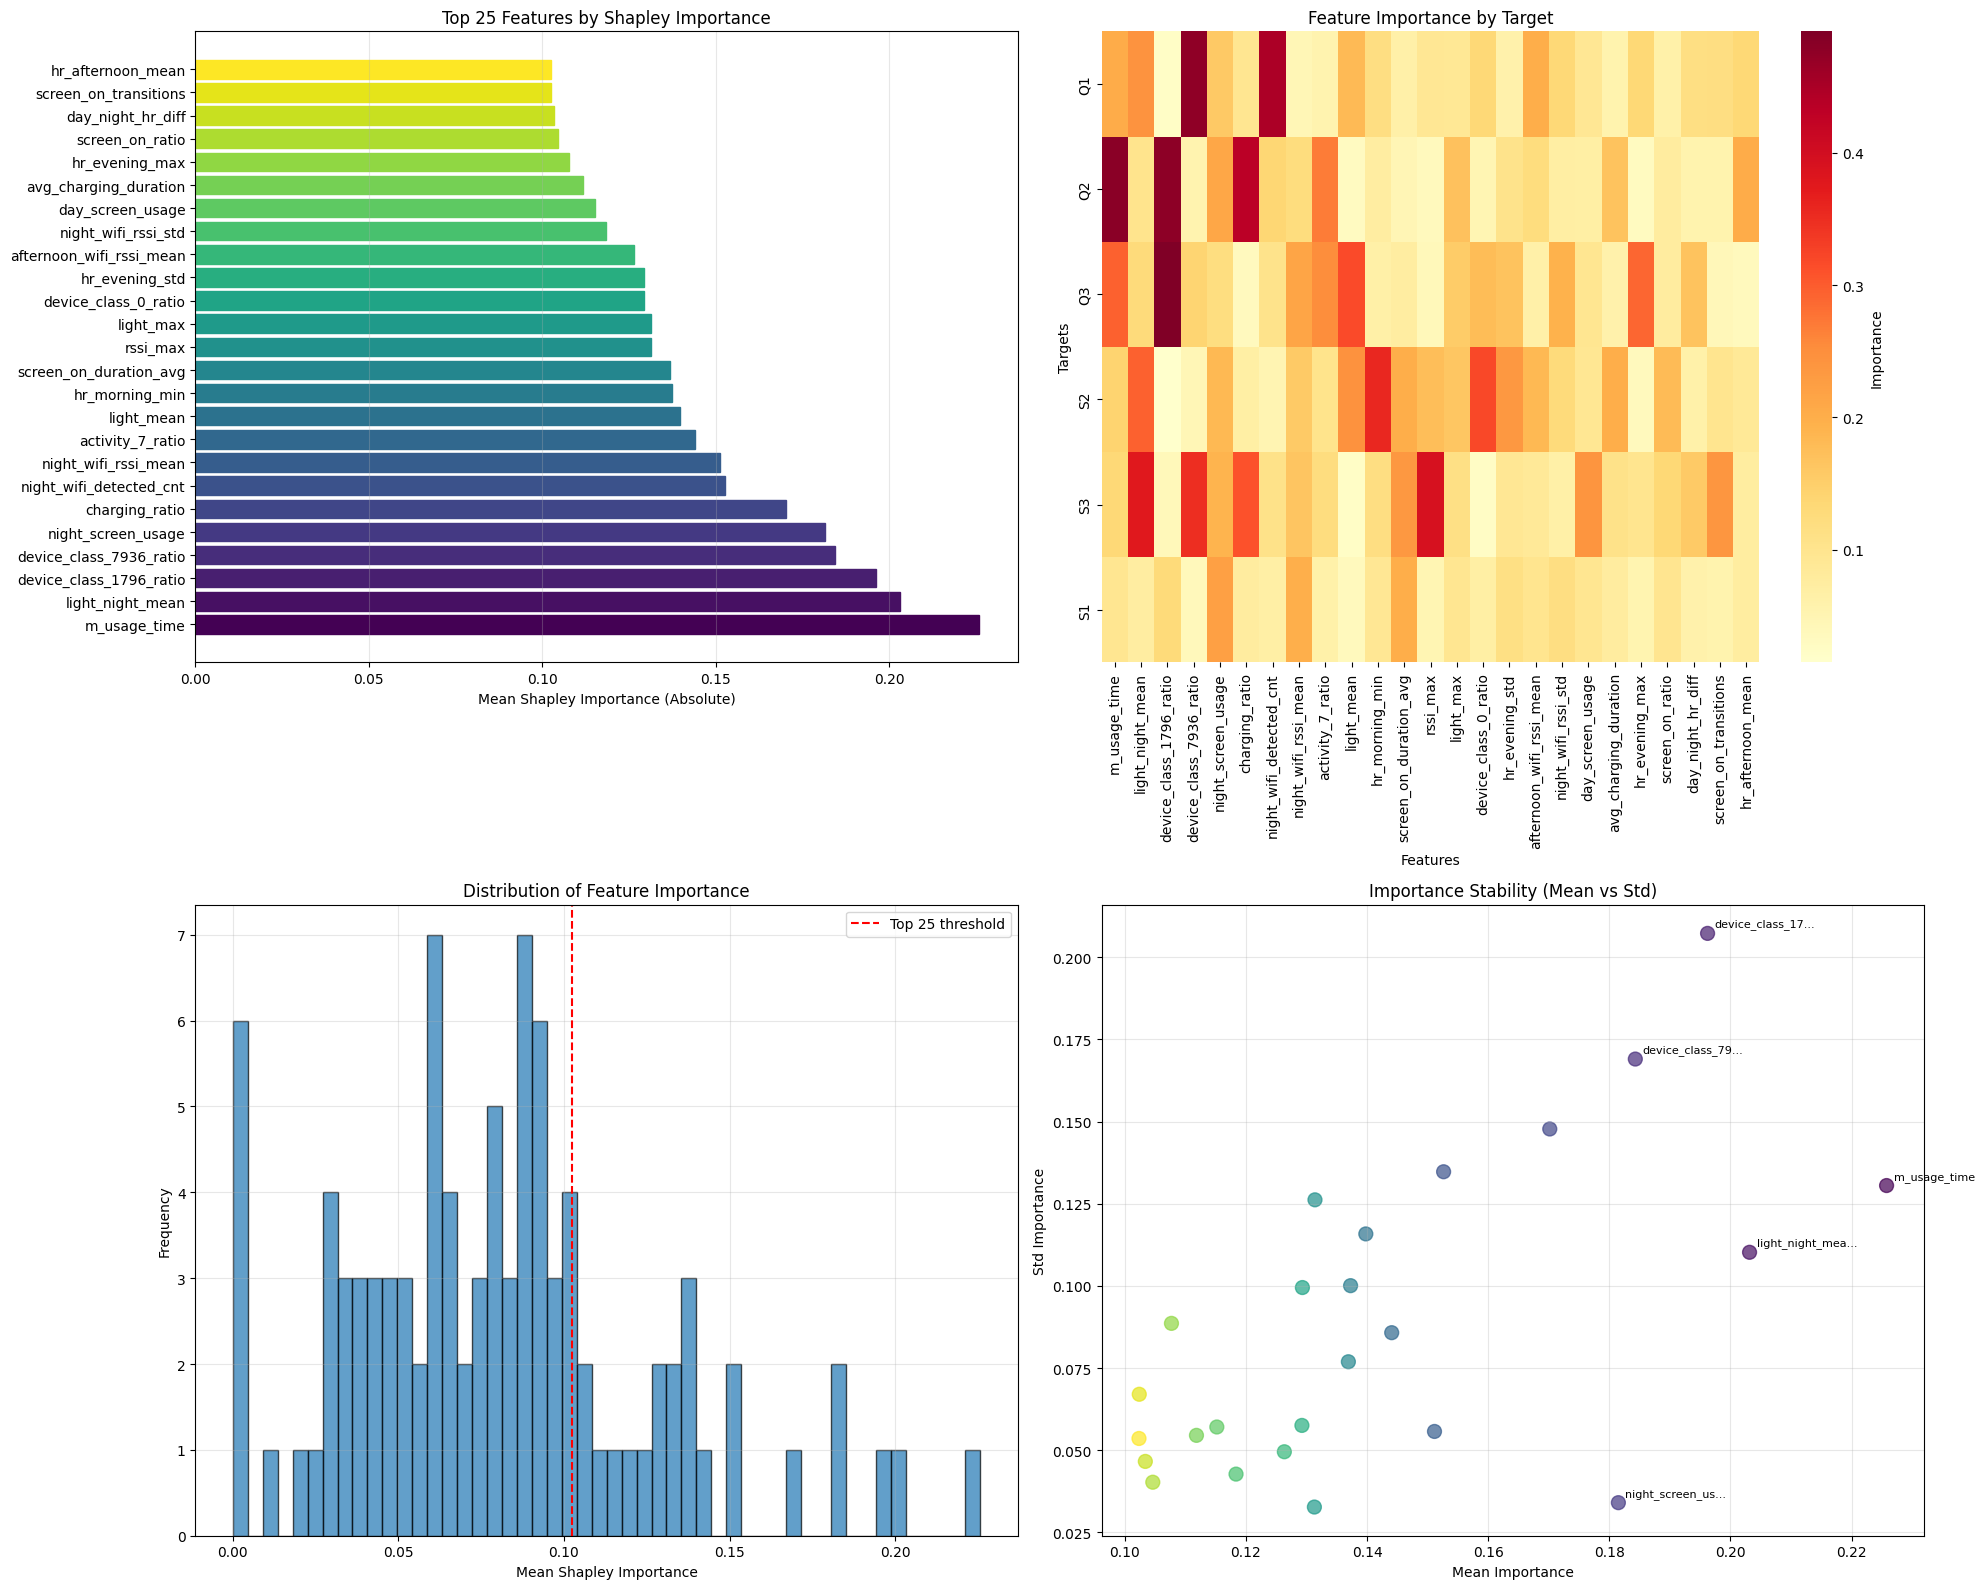


선택된 특성으로 데이터셋 크기: (450, 25)

상위 20개 변수의 상세 정보:
                          rank  mean_importance  std_importance
m_usage_time                 1           0.2258          0.1305
light_night_mean             2           0.2031          0.1102
device_class_1796_ratio      3           0.1962          0.2072
device_class_7936_ratio      4           0.1843          0.1690
night_screen_usage           5           0.1815          0.0341
charging_ratio               6           0.1702          0.1477
night_wifi_detected_cnt      7           0.1526          0.1347
night_wifi_rssi_mean         8           0.1511          0.0557
activity_7_ratio             9           0.1441          0.0858
light_mean                  10           0.1398          0.1158
hr_morning_min              11           0.1373          0.1001
screen_on_duration_avg      12           0.1369          0.0769
rssi_max                    13           0.1314          0.1262
light_max                   14           0.1313         

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.preprocessing import RobustScaler
import shap
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def calculate_multivariate_shapley_importance(X, y_dict, top_n=TOP_N):
    """
    다변량 타겟에 대한 Shapley value 기반 변수 중요도 계산
    
    Parameters:
    -----------
    X : DataFrame
        특성 데이터
    y_dict : dict
        {'target_name': target_series} 형태의 타겟 딕셔너리
    top_n : int
        상위 몇 개 변수를 선택할지
    
    Returns:
    --------
    top_features : list
        상위 중요 변수 리스트
    importance_df : DataFrame
        변수별 중요도 정보
    """
    
    # 1. 각 타겟별 Shapley value 계산
    all_shapley_values = {}
    feature_importance_by_target = {}
    
    print("타겟별 Shapley value 계산 중...")
    
    for target_name, y in y_dict.items():
        print(f"Processing {target_name}...")
        
        # 결측값 제거
        valid_idx = ~y.isna()
        X_valid = X[valid_idx]
        y_valid = y[valid_idx]
        
        if len(y_valid.unique()) <= 1:
            print(f"Warning: {target_name} has only one unique value, skipping...")
            continue
            
        # 분류/회귀 자동 판별 및 LGBM 모델 사용
        if len(y_valid.unique()) <= 10:  # 분류로 간주
            model = LGBMClassifier(
                n_estimators=100, 
                random_state=42, 
                n_jobs=-1,
                verbosity=-1,  # 로그 출력 억제
                force_col_wise=True  # 메모리 효율성
            )
        else:  # 회귀로 간주
            model = LGBMRegressor(
                n_estimators=100, 
                random_state=42, 
                n_jobs=-1,
                verbosity=-1,
                force_col_wise=True
            )
        
        # 모델 학습
        model.fit(X_valid, y_valid)
        
        # SHAP explainer 생성 (TreeExplainer 사용 - LGBM 호환)
        explainer = shap.TreeExplainer(model)
        
        # Shapley values 계산 (샘플 수가 많으면 일부만 사용)
        sample_size = min(1000, len(X_valid))
        X_sample = X_valid.sample(n=sample_size, random_state=42)
        shap_values = explainer.shap_values(X_sample)
        
        # 다중클래스 분류의 경우 처리
        if isinstance(shap_values, list):
            # 여러 클래스의 shap values를 절대값 평균으로 통합
            combined_shap = np.mean([np.abs(sv) for sv in shap_values], axis=0)
            feature_importance = combined_shap.mean(axis=0)
        else:
            # 이진분류 또는 회귀의 경우
            if len(shap_values.shape) == 3:  # 3차원인 경우 (n_samples, n_features, n_classes)
                # 클래스별 절대값 평균
                feature_importance = np.abs(shap_values).mean(axis=(0, 2))
            else:  # 2차원인 경우 (n_samples, n_features)
                feature_importance = np.abs(shap_values).mean(axis=0)
        
        # SHAP values 저장 (시각화용)
        if isinstance(shap_values, list):
            all_shapley_values[target_name] = shap_values[0]  # 첫 번째 클래스만 저장
        else:
            if len(shap_values.shape) == 3:
                all_shapley_values[target_name] = shap_values[:, :, 0]  # 첫 번째 클래스만 저장
            else:
                all_shapley_values[target_name] = shap_values
        feature_importance_by_target[target_name] = pd.Series(
            feature_importance, 
            index=X_valid.columns
        )
    
    # 2. 타겟별 중요도를 평균내어 종합 중요도 계산
    print("\n종합 중요도 계산 중...")
    
    # 모든 타겟에 공통으로 있는 특성들만 사용
    common_features = set(X.columns)
    for importance in feature_importance_by_target.values():
        common_features = common_features.intersection(set(importance.index))
    
    common_features = list(common_features)
    
    # 타겟별 중요도를 DataFrame으로 정리
    importance_matrix = pd.DataFrame(index=common_features)
    for target_name, importance in feature_importance_by_target.items():
        importance_matrix[target_name] = importance[common_features]
    
    # 평균 중요도 계산 (각 타겟의 가중치는 동일)
    importance_matrix['mean_importance'] = importance_matrix.mean(axis=1)
    importance_matrix['std_importance'] = importance_matrix.std(axis=1)
    
    # 상위 변수 선택
    top_features = importance_matrix.nlargest(top_n, 'mean_importance').index.tolist()
    
    return top_features, importance_matrix, all_shapley_values, feature_importance_by_target

def plot_feature_importance(importance_df, top_n=TOP_N):
    """변수 중요도 시각화"""
    
    # 상위 변수들
    top_importance = importance_df.nlargest(top_n, 'mean_importance')
    
    # 1. 종합 중요도 바 플롯
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 상위 변수 바 플롯
    ax1 = axes[0, 0]
    bars = ax1.barh(range(len(top_importance)), top_importance['mean_importance'])
    ax1.set_yticks(range(len(top_importance)))
    ax1.set_yticklabels(top_importance.index, fontsize=10)
    ax1.set_xlabel('Mean Shapley Importance (Absolute)')
    ax1.set_title(f'Top {top_n} Features by Shapley Importance')
    ax1.grid(axis='x', alpha=0.3)
    
    # 색상 그라데이션 적용
    colors = plt.cm.viridis(np.linspace(0, 1, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # 2. 타겟별 중요도 히트맵
    ax2 = axes[0, 1]
    target_cols = [col for col in importance_df.columns if col not in ['mean_importance', 'std_importance']]
    if target_cols:
        heatmap_data = top_importance[target_cols].T
        sns.heatmap(heatmap_data, annot=False, cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Importance'})
        ax2.set_title('Feature Importance by Target')
        ax2.set_xlabel('Features')
        ax2.set_ylabel('Targets')
    
    # 3. 중요도 분포
    ax3 = axes[1, 0]
    ax3.hist(importance_df['mean_importance'], bins=50, alpha=0.7, edgecolor='black')
    ax3.axvline(top_importance['mean_importance'].min(), color='red', linestyle='--', 
                label=f'Top {top_n} threshold')
    ax3.set_xlabel('Mean Shapley Importance')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Feature Importance')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # 4. 상위 변수들의 안정성 (표준편차)
    ax4 = axes[1, 1]
    scatter = ax4.scatter(top_importance['mean_importance'], top_importance['std_importance'], 
                         c=range(len(top_importance)), cmap='viridis', alpha=0.7, s=100)
    ax4.set_xlabel('Mean Importance')
    ax4.set_ylabel('Std Importance')
    ax4.set_title('Importance Stability (Mean vs Std)')
    ax4.grid(alpha=0.3)
    
    # 상위 5개 변수에 라벨 추가
    for i, (idx, row) in enumerate(top_importance.head().iterrows()):
        ax4.annotate(idx[:15] + '...' if len(idx) > 15 else idx, 
                    (row['mean_importance'], row['std_importance']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# 메인 실행 코드
if __name__ == "__main__":
    # 타겟 딕셔너리 생성
    y_dict = {}
    for target in targets_binary:
        y_dict[target] = train_df[target]
    y_dict[target_multiclass] = train_df[target_multiclass]
    
    print(f"분석할 타겟: {list(y_dict.keys())}")
    print(f"특성 개수: {X.shape[1]}")
    print(f"샘플 개수: {X.shape[0]}")
    
    # Shapley 중요도 계산
    top_features, importance_df, shap_values, target_importance = calculate_multivariate_shapley_importance(
        X, y_dict, top_n=TOP_N
    )
    
    # 결과 출력
    print(f"\n=== 상위 20개 중요 변수 ===")
    for i, feature in enumerate(top_features, 1):
        importance = importance_df.loc[feature, 'mean_importance']
        print(f"{i:2d}. {feature}: {importance:.4f}")
    
    # 시각화
    plot_feature_importance(importance_df, top_n=TOP_N)
    




    # ✅ 선택된 특성으로 새로운 데이터셋 생성 
    X_selected = X[top_features]  
    test_X_selected = test_X[top_features] if 'test_X' in locals() else None
    
    print(f"\n선택된 특성으로 데이터셋 크기: {X_selected.shape}")
    
    # 결과 저장용 DataFrame
    result_df = importance_df.nlargest(20, 'mean_importance').copy()
    result_df['rank'] = range(1, len(result_df) + 1)
    
    print(f"\n상위 20개 변수의 상세 정보:")
    print(result_df[['rank', 'mean_importance', 'std_importance']].round(4))

In [49]:
top_features

['m_usage_time',
 'light_night_mean',
 'device_class_1796_ratio',
 'device_class_7936_ratio',
 'night_screen_usage',
 'charging_ratio',
 'night_wifi_detected_cnt',
 'night_wifi_rssi_mean',
 'activity_7_ratio',
 'light_mean',
 'hr_morning_min',
 'screen_on_duration_avg',
 'rssi_max',
 'light_max',
 'device_class_0_ratio',
 'hr_evening_std',
 'afternoon_wifi_rssi_mean',
 'night_wifi_rssi_std',
 'day_screen_usage',
 'avg_charging_duration',
 'hr_evening_max',
 'screen_on_ratio',
 'day_night_hr_diff',
 'screen_on_transitions',
 'hr_afternoon_mean']

### 모델링

In [ ]:
# LightGBM 라이브러리 임포트
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping 

# GridSearch를 위한 교차 검증 설정
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# LightGBM 기본 파라미터 설정
lgbm_params = {
    'n_estimators': 1000,
    'learning_rate': 0.03,
    # 'device': 'gpu',  # GPU 사용 설정
    'random_state': 42,
    # 'n_jobs': 1, 
    'n_jobs': -1,
    'verbosity': -1
}

# 이진 분류 모델 성능 향상을 위한 그리드 서치 파라미터
binary_param_grid = {
    'learning_rate': [0.01, 0.03],
    'n_estimators': [500, 1000],
    'num_leaves': [50, 100],
    'max_depth': [-1, 5],
    'min_child_samples': [10, 30],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1],
    # 'device': ['gpu'],  # GPU 고정

}

# 다중 분류 모델 성능 향상을 위한 그리드 서치 파라미터
multi_param_grid = {
    'learning_rate': [0.01, 0.03],
    'n_estimators': [500, 1000],
    'num_leaves': [50, 100],
    'max_depth': [-1, 5],
    'min_child_samples': [10, 30],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1],
    # 'device': ['gpu'],  # 여기도 GPU 추가

}

In [51]:
print("\n===== 오토인코더를 사용한 고급 특성 추출 =====")

# 하이퍼파라미터 설정
encoding_dim = min(64, X_selected.shape[1])  # 인코딩 차원 (원본 특성 수보다 작게 설정)
batch_size = 64
epochs = 100

# 입력 차원
input_dim = X_selected.shape[1]

# 오토인코더 모델 구축
input_layer = Input(shape=(input_dim,))

# 인코더 부분
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# 디코더 부분
decoded = Dense(64, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# 전체 오토인코더 모델
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# 인코더 부분만 추출 (특성 추출용)
encoder = Model(input_layer, encoded)



===== 오토인코더를 사용한 고급 특성 추출 =====


2025-06-07 23:09:01.366055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-07 23:09:01.643282: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [52]:
# 1. 스케일링 적용 (RobustScaler 또는 StandardScaler)
from sklearn.preprocessing import RobustScaler 

scaler = RobustScaler()
X_selected = scaler.fit_transform(X_selected)
test_X_selected = scaler.transform(test_X_selected)


In [53]:
# 훈련/검증 세트 분리
X_train_auto, X_val_auto = train_test_split(X_selected, test_size=0.2, random_state=42)

# 조기 종료 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 오토인코더 모델 학습
print("오토인코더 학습 중...")
autoencoder.fit(
    X_train_auto, X_train_auto,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_val_auto, X_val_auto),
    callbacks=[early_stopping],
    verbose=1
)

# 인코딩된 특성 추출
print("인코딩된 특성 추출 중...")
encoded_features_train = encoder.predict(X_selected)
encoded_features_test = encoder.predict(test_X_selected)

# 원본 특성과 인코딩된 특성 결합
X_combined = np.hstack([X_selected, encoded_features_train])
test_X_combined = np.hstack([test_X_selected, encoded_features_test])

print(f"원본 특성 수: {X_selected.shape[1]}")
print(f"인코딩된 특성 수: {encoded_features_train.shape[1]}")
print(f"결합된 특성 수: {X_combined.shape[1]}")


오토인코더 학습 중...
Epoch 1/100
6/6 [==============================] - 1s 34ms/step - loss: 3.0750 - val_loss: 3.1905
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 2.9692 - val_loss: 3.1550
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 2.9246 - val_loss: 3.1241
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 2.8903 - val_loss: 3.0973
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 2.8619 - val_loss: 3.0761
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 2.8367 - val_loss: 3.0563
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 2.8099 - val_loss: 3.0365
Epoch 8/100
6/6 [==============================] - 0s 9ms/step - loss: 2.7932 - val_loss: 3.0181
Epoch 9/100
6/6 [==============================] - 0s 9ms/step - loss: 2.7836 - val_loss: 2.9998
Epoch 10/100
6/6 [==============================] - 0s 9ms/step - loss: 2.7547 - val_loss: 2.9823
Epoch 11/100


In [54]:
# ------------------ 결합된 특성으로 이진 분류 모델 학습 ------------------

# 이진 분류 모델 최적화 및 학습
binary_preds_combined = {}
for col in targets_binary:
    y = train_df[col]
    
    # 이진 분류용 모델 설정
    binary_model = LGBMClassifier(objective='binary', **lgbm_params)
    
    # 그리드 서치로 최적 파라미터 찾기
    grid_search = GridSearchCV(
        estimator=binary_model,
        param_grid=binary_param_grid,
        scoring='f1',  # 또는 'roc_auc', 'precision', 'recall' 등 문제에 적합한 지표 선택
        cv=cv,
        verbose=1,
        # n_jobs=-1
        n_jobs=1  # GPU 사용시 1로 설정 (중요!)


    )
    
    print(f"\n{col} 이진 분류 모델 최적화 중 (결합된 특성 사용)...")
    grid_search.fit(X_combined, y)
    
    print(f"최적 파라미터: {grid_search.best_params_}")
    print(f"최고 점수: {grid_search.best_score_:.4f}")
    
    # 최적 모델로 예측
    best_model = grid_search.best_estimator_
    binary_preds_combined[col] = best_model.predict(test_X_combined)


Q1 이진 분류 모델 최적화 중 (결합된 특성 사용)...
Fitting 3 folds for each of 288 candidates, totalling 864 fits


KeyboardInterrupt: 

In [ ]:
# ------------------ 결합된 특성으로 다중 분류 모델 학습 ------------------

# 다중 분류 (S1) 모델 최적화 및 학습
y_multi = train_df['S1']
n_classes = len(y_multi.unique())

# 다중 분류용 모델 설정
multiclass_model = LGBMClassifier(objective='multiclass', num_class=n_classes, **lgbm_params)

# 그리드 서치로 최적 파라미터 찾기
grid_search_multi = GridSearchCV(
    estimator=multiclass_model,
    param_grid=multi_param_grid,
    scoring='f1_macro',  # 다중 분류에서는 macro 평균 사용
    cv=cv,
    verbose=1,
    n_jobs=-1
)

print("\nS1 다중 분류 모델 최적화 중 (결합된 특성 사용)...")
grid_search_multi.fit(X_combined, y_multi)

print(f"최적 파라미터: {grid_search_multi.best_params_}")
print(f"최고 점수: {grid_search_multi.best_score_:.4f}")

# 최적 모델로 예측
best_multi_model = grid_search_multi.best_estimator_
multiclass_pred_combined = best_multi_model.predict(test_X_combined)

# 검증 데이터에 대한 성능 평가
X_train_comb, X_val_comb, y_train, y_val = train_test_split(
    X_combined, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

# 최적 파라미터를 사용하여 검증용 모델 학습
eval_model_comb = LGBMClassifier(**grid_search_multi.best_params_)
eval_model_comb.fit(X_train_comb, y_train)

# 예측 및 평가
y_pred_comb = eval_model_comb.predict(X_val_comb)

print("\n===== 오토인코더 + LightGBM 결합 모델 평가 (S1) =====")
print(classification_report(y_val, y_pred_comb))
print("\n혼동 행렬:")
print(confusion_matrix(y_val, y_pred_comb))

In [ ]:
# ------------------ 성능 비교 분석 ------------------

# 원본 특성만 사용한 모델과 결합 특성 모델 비교
print("\n===== 원본 특성 vs 결합 특성 모델 성능 비교 =====")

# 원본 특성 모델 재학습 (비교용)
X_train_orig, X_val_orig, y_train, y_val = train_test_split(
    X_selected, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

eval_model_orig = LGBMClassifier(**grid_search_multi.best_params_)
eval_model_orig.fit(X_train_orig, y_train)
y_pred_orig = eval_model_orig.predict(X_val_orig)

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 정확도 비교
acc_orig = accuracy_score(y_val, y_pred_orig)
acc_comb = accuracy_score(y_val, y_pred_comb)
print(f"정확도 - 원본 특성: {acc_orig:.4f}, 결합 특성: {acc_comb:.4f}, 향상: {(acc_comb-acc_orig)*100:.2f}%")

# F1 점수 비교 (다중 분류는 macro 평균)
f1_orig = f1_score(y_val, y_pred_orig, average='macro')
f1_comb = f1_score(y_val, y_pred_comb, average='macro')
print(f"F1 점수 - 원본 특성: {f1_orig:.4f}, 결합 특성: {f1_comb:.4f}, 향상: {(f1_comb-f1_orig)*100:.2f}%")


In [ ]:
# 검증 데이터에 대한 성능 평가
X_train_sel, X_val_sel, y_train, y_val = train_test_split(
    X_selected, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

# 최적 파라미터를 사용하여 검증용 모델 학습
eval_model_sel = LGBMClassifier(**grid_search_multi.best_params_)
eval_model_sel.fit(X_train_sel, y_train)

# 예측 및 평가
y_pred_sel = eval_model_sel.predict(X_val_sel)

print("\n===== LightGBM 최적화 모델 평가 (S1) =====")
print(classification_report(y_val, y_pred_sel))
print("\n혼동 행렬:")
print(confusion_matrix(y_val, y_pred_sel))

# # 성능 평가 (원본 모델과 비교)
# # 검증 데이터 분할
# X_train_sel, X_val_sel, y_train, y_val = train_test_split(
#     X_selected, y_multi, test_size=0.2, random_state=42, stratify=y_multi
# )

# # 평가용 모델 학습
# eval_model_sel = LGBMClassifier(**multiclass_params)
# eval_model_sel.fit(X_train_sel, y_train)

# # 예측 및 평가
# y_pred_sel = eval_model_sel.predict(X_val_sel)

# print("\n===== LightGBM 그룹 기반 특성 선택 모델 평가 (S1) =====")
# print(classification_report(y_val, y_pred_sel))

### 제출

In [ ]:
# sample 기반 제출 포맷 가져오기
submission_final = sample_submission[['subject_id', 'sleep_date', 'lifelog_date']].copy()

# lifelog_date 기준으로 string → date 형식 통일
submission_final['lifelog_date'] = pd.to_datetime(submission_final['lifelog_date']).dt.date

# ID 만들기 (submission에서 예측한 결과와 연결하기 위해)
submission_final['ID'] = submission_final['subject_id'] + '_' + submission_final['lifelog_date'].astype(str)

In [ ]:

# 예측 결과 연결할 수 있도록 동일한 순서로 정렬
# 보통 예측 결과는 test_df 기준이므로 정렬 보장되어야 함
assert len(submission_final) == len(multiclass_pred_combined) # shape 체크

# 다중 분류 예측 붙이기
submission_final['S1'] = multiclass_pred_combined

# 이진 분류 결과 붙이기
for col in ['Q1', 'Q2', 'Q3', 'S2', 'S3']:
    submission_final[col] = binary_preds_combined[col].astype(int) # 확률 아닌 class 예측


In [ ]:

# 최종 제출 형식 정렬
submission_final = submission_final[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]

# 저장
submission_final.to_csv(submission_folder + submission_file, index=False)

# VSCode에서는 files.download()가 작동하지 않으므로 대체

print(f"✅ 제출 파일이 저장되었습니다: {os.path.abspath(submission_file)}")